### Phase-based encoding in pairwise neural interactions

In [3]:
import os

In [4]:
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate_kuramoto

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dt = 0.001  # Integration time-step
fs = 1 / dt
f = 40  # Natural frequency
beta = 3.5  # Noise variance
A = np.array([[0, 1], [0, 0]]).T
ntrials = 500
time = np.arange(-0.5, 1, 1 / fs)  # Time array
T = time.shape[0]

In [7]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.4
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [8]:
data = []
for trial in tqdm(range(ntrials)):
    data += [
        simulate_kuramoto(
            10 * A, coupling * CS[trial], f, fs, beta, T, seed=seeds[trial], decim=1
        )
    ]

100%|██████████| 500/500 [01:18<00:00,  6.39it/s]


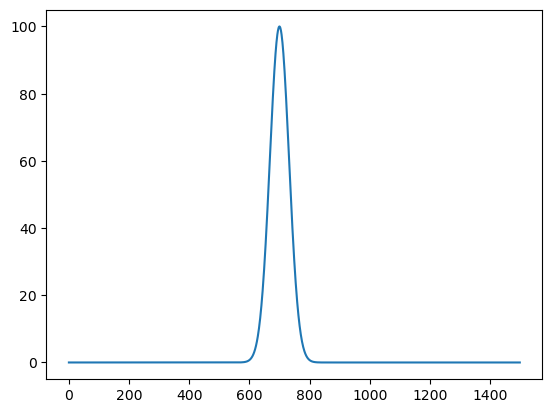

In [9]:
plt.plot(coupling * CS[trial])

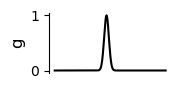

In [10]:
plt.figure(figsize=(4 / 2.54, 2  /2.54))
ax = plt.subplot(111)
plt.plot(time, coupling, "k")
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.xticks([])
plt.ylabel("g", fontsize=12)
plt.savefig("figures/coupling_strength.pdf")

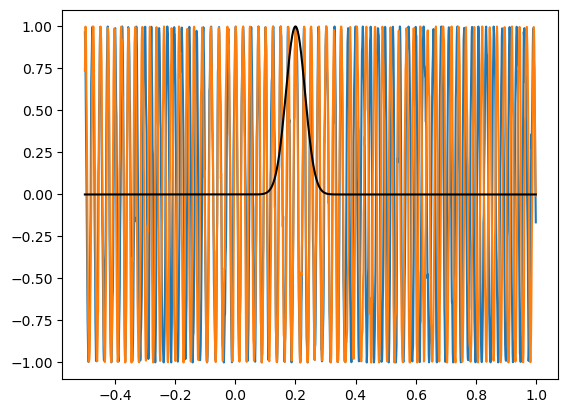

In [11]:

plt.plot(time[::1], data[-1].real.T)
plt.plot(time, coupling, "k")

In [12]:
h = scipy.signal.hilbert(np.stack(data).real, axis=2)

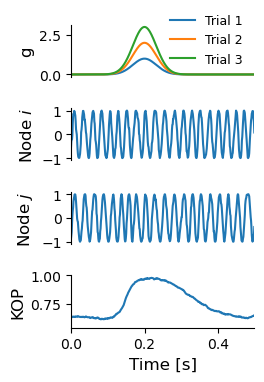

In [13]:
plt.figure(figsize=(6 / 2.54, 10  /2.54))
ax = plt.subplot(411)
[plt.plot(time, coupling * i) for i in [1, 2, 3] ]
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.legend(["Trial 1", "Trial 2", "Trial 3"], fontsize=9, frameon=False)
plt.xticks([])
plt.ylabel("g", fontsize=12)
plt.xlim(0, 0.5)

ax = plt.subplot(412)
plt.plot(time[::1], data[250].real.T[:, 0])
plt.xlim(0, 0.5)
plt.xticks([])
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.ylabel("Node $i$", fontsize=12)


ax = plt.subplot(413)
plt.plot(time[::1], data[250].real.T[:, 1])
plt.xlim(0, 0.5)
plt.xticks([])
[ax.spines[key].set_visible(False) for key in ["top", "right", "bottom"]]
plt.ylabel("Node $j$", fontsize=12)

ax = plt.subplot(414)
plt.plot(time[::1], np.abs(h.mean(1)).mean(0))
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("KOP", fontsize=12)
plt.xlim(0, 0.5)

plt.subplots_adjust(hspace=.6)

plt.savefig("figures/coupling_strength_kop.pdf")

In [14]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    fs / 1,
    freqs,
    n_cycles=freqs / 2,
    decim=1,
    output="complex",
    verbose=None,
)

In [15]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

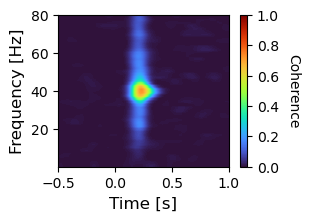

In [16]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
    vmax=1,
)
cbar = plt.colorbar()
cbar.set_label("Coherence", rotation=270, labelpad=15)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/coherece2nodes.pdf")

In [17]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [18]:
z = W[:, 0] * np.conj(W[:, 1])


dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, ntrials), (1, 2)), (z.shape[1], z.shape[2])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [19]:
MI_PHI = mi_fcn_time_frequency(dphi, labels[None], False, False)

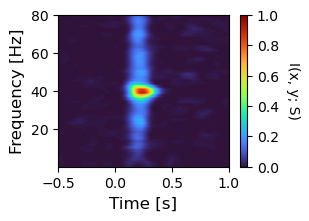

In [20]:
plt.figure(figsize=(7 / 2.54, 5 / 2.54))


plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
    vmin=0,
    vmax=1
)
cbar = plt.colorbar()
cbar.set_label(r"I(x, y; S)", rotation=270, labelpad=15)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Frequency [Hz]", fontsize=12)

plt.savefig("figures/MI2nodes.pdf")

In [19]:
scipy.io.loadmat("kuramoto_matlab.mat")["data"].transpose(1, 0, 2)[:, :2].shape

(500, 2, 901)

In [20]:
data2 = scipy.io.loadmat("kuramoto_matlab.mat")["data"].transpose(1, 0, 2)[:, [0, 2]]

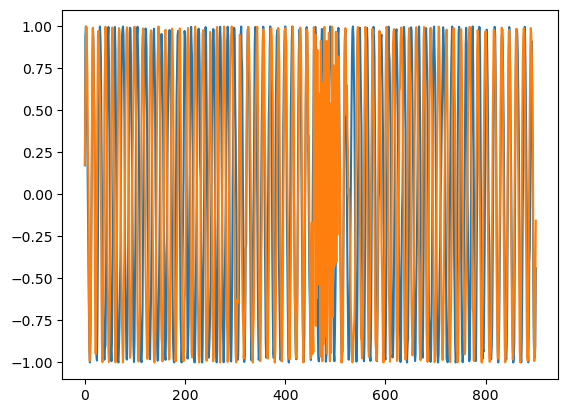

In [21]:
plt.plot(data2[-1].T)

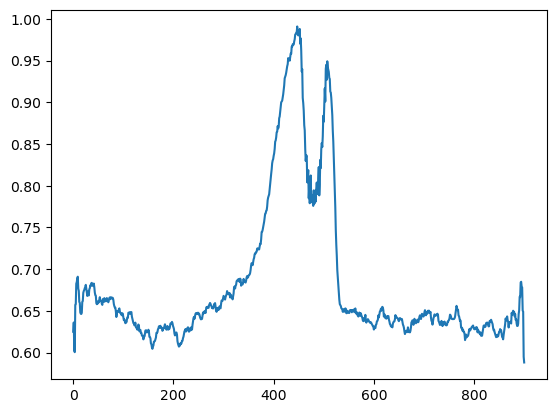

In [22]:
h = scipy.signal.hilbert(np.stack(data2).real, axis=2)
plt.plot(np.abs(h.mean(1)).mean(0))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished


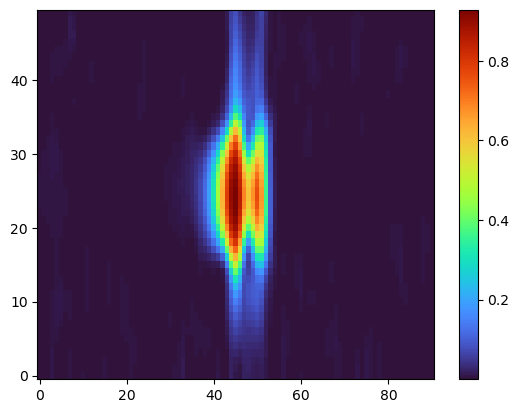

In [23]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data2,
    600,
    freqs,
    n_cycles=freqs / 7,
    decim=10,
    output="complex",
    verbose=None,
)

Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
)
plt.colorbar()

In [30]:
z = W[:, 0] * np.conj(W[:, 1])

dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, 500), (1, 2)), (z.shape[1], z.shape[2])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

MI_PHI = mi_fcn_time_frequency(z.real[None], labels[None], False, True)

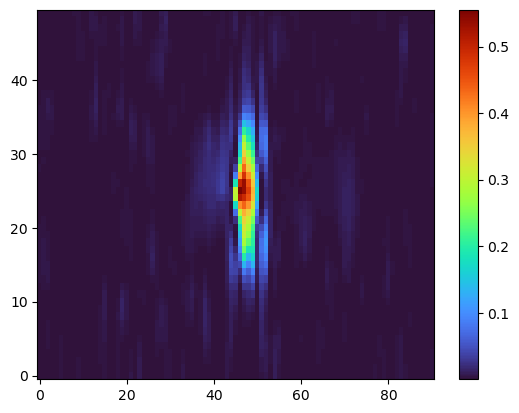

In [31]:
plt.imshow(MI_PHI, aspect="auto", origin="lower", cmap="turbo")
plt.colorbar()

In [28]:
data2.shape

(500, 2, 901)

In [29]:
901 / 600

1.5016666666666667

In [30]:
import numpy as np


def kuramoto_delays_run_timevar(C, f, fs, icoup, K, npoints):
    """
    Simulates the Kuramoto model with time delays.

    Parameters:
        C (ndarray): Connectivity matrix (NxN)
        D (ndarray): Distance matrix (NxN)
        f (float): Natural frequency (Hz)
        fs (float): Sampling frequency (Hz)
        icoup (array): Coupling scaling values per time step (length = npoints)
        K (float): Global coupling constant
        MD (float): Mean delay in seconds
        npoints (int): Number of simulation time points

    Returns:
        TS (ndarray): Simulated time series (NxT)
        Phases (ndarray): Phase time series (NxT)
    """
    dt = 0.05 / fs  # Integration time step
    noise = 3.5
    N = C.shape[0]
    Omegas = 2 * np.pi * f * np.ones(N) * dt  # Natural frequencies
    kC = K * C * dt  # Coupling matrix scaled
    dsig = np.sqrt(dt) * noise  # Scaled noise

    # Initialize phase history
    Phases_History = (
        2 * np.pi * np.random.rand(N, 1) + Omegas[:, None] * np.arange(1, 2)
    ) % (2 * np.pi)
    Phases = np.zeros((N, npoints))
    sumz = np.zeros(N)

    # print(f"Now running for K={K}, mean Delay = {MD * 1e3:.2f} ms")

    for t in range(npoints):
        Phase_Now = Phases_History[:, -1]  # Current phase
        for n in range(N):
            sumzn = 0
            for p in range(N):
                if kC[n, p] != 0:
                    sumzn += icoup[t] * kC[n, p] * np.sin(Phase_Now[p] - Phase_Now[n])
            sumz[n] = sumzn

        # Update last history entry
        Phases_History[:, -1] = Phase_Now + Omegas + sumz + dsig * np.random.randn(N)

        # Save current phase
        Phases[:, t] = Phases_History[:, -1]

    # Convert phases to time series using sine and FFT/iFFT
    Fourier = np.fft.fft(np.sin(Phases), axis=1)
    TS = np.real(np.fft.ifft(Fourier, axis=1))

    return TS  # For Kuramoto phases_history is cast to float
    # Randomly initialize phases and keeps it only up to max delay
    phases_History = (
        2 * np.pi * np.random.rand(N, 1) + omegas[:, None] * np.arange(1, 2)
    ) % (2 * np.pi)

In [31]:
data += [
    kuramoto_delays_run_timevar(A, 40, 600, coupling * Amplitudes[trial], 10, T)
    for trial in tqdm(range(ntrials))
]

  0%|                                                                                                                                                           | 0/500 [00:00<?, ?it/s]

NameError: name 'Amplitudes' is not defined

In [ ]:
plt.plot(time[::1], data[-1].real.T)

plt.xlim(0, 0.1)

In [ ]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    600,
    freqs,
    n_cycles=freqs / 7,
    decim=10,
    output="complex",
    verbose=None,
)

In [ ]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

In [ ]:
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-1, 2, 0.1, 80],
)
plt.colorbar()

In [48]:
a = [
    0.251673,
    0.289853,
    0.340637,
    0.389915,
    0.414113,
    0.465836,
    0.517131,
    0.540658,
    0.577094,
    0.624435,
    0.656397,
    0.678981,
    0.712928,
    0.752745,
    0.787758,
    0.817019,
    0.847542,
    0.869901,
    0.896906,
    0.919587,
    0.939456,
    0.949902,
    0.960004,
    0.974531,
    0.983375,
    0.989193,
    0.995573,
    0.999142,
    0.999990,
    0.999025,
    0.996623,
    0.992738,
    0.988959,
    0.983813,
    0.977744,
    0.971144,
    0.963842,
    0.955421,
    0.945474,
    0.928858,
    0.917690,
    0.897338,
    0.872728,
    0.846573,
    0.820658,
    0.792452,
    0.767313,
    0.739756,
    0.718353,
    0.691574,
    0.665048,
    0.646054,
    0.611449,
    0.575176,
    0.527107,
    0.503149,
    0.454536,
    0.408982,
    0.357711,
    0.327439,
    0.290352,
    0.258199,
    0.214012,
    0.172796,
    0.133525,
    0.082289,
    0.036051,
    -0.007466,
    -0.063815,
    -0.116817,
    -0.147664,
    -0.172686,
    -0.213520,
    -0.270682,
    -0.319848,
    -0.346661,
    -0.389920,
    -0.418740,
    -0.459381,
    -0.505513,
    -0.543097,
    -0.589418,
    -0.631152,
    -0.653019,
    -0.683625,
    -0.719382,
    -0.740799,
    -0.764759,
    -0.790266,
    -0.806364,
    -0.831320,
    -0.860330,
    -0.877661,
    -0.891118,
    -0.907007,
    -0.926790,
    -0.946117,
    -0.963166,
    -0.971524,
    -0.982436,
    -0.990617,
    -0.995195,
    -0.998927,
    -0.999899,
    -0.999722,
    -0.997780,
    -0.994798,
    -0.987024,
    -0.977882,
    -0.964771,
    -0.949864,
    -0.938874,
    -0.919871,
    -0.901583,
    -0.885032,
    -0.869381,
    -0.851872,
    -0.828535,
    -0.803169,
    -0.772491,
    -0.743365,
    -0.724858,
    -0.693749,
    -0.653428,
    -0.629675,
    -0.585747,
    -0.549451,
    -0.527467,
    -0.481973,
    -0.435776,
    -0.387970,
    -0.347822,
    -0.318687,
    -0.276618,
    -0.228107,
    -0.185458,
    -0.158859,
    -0.133726,
    -0.091313,
    -0.040114,
    0.015657,
    0.049963,
    0.109405,
    0.156224,
    0.208849,
    0.244259,
    0.296933,
    0.323360,
    0.374230,
    0.409630,
    0.456943,
    0.491123,
    0.526081,
    0.556782,
    0.584103,
    0.621158,
    0.645701,
    0.684684,
    0.718451,
    0.758411,
    0.786409,
    0.810330,
    0.834411,
    0.860849,
    0.889210,
    0.903544,
    0.917323,
    0.927196,
    0.938922,
    0.955211,
    0.969236,
    0.975808,
    0.987175,
    0.994056,
    0.998278,
    0.999986,
    0.999753,
    0.997741,
    0.992399,
    0.983844,
    0.971734,
    0.959141,
    0.948554,
    0.935557,
    0.912733,
    0.894126,
    0.865607,
    0.849409,
    0.830118,
    0.802775,
    0.784117,
    0.749136,
    0.730984,
    0.697488,
    0.665103,
    0.645814,
    0.602788,
    0.560123,
    0.538432,
    0.514976,
    0.477465,
    0.430644,
    0.402700,
    0.362831,
    0.321804,
    0.268308,
    0.232968,
    0.187998,
    0.147736,
    0.115500,
    0.073197,
    0.034215,
    -0.021683,
    -0.074293,
    -0.126732,
    -0.181740,
    -0.217008,
    -0.268122,
    -0.294075,
    -0.338097,
    -0.375411,
    -0.405399,
    -0.442337,
    -0.479436,
    -0.527224,
    -0.577154,
    -0.611107,
    -0.650121,
    -0.688903,
    -0.719457,
    -0.755075,
    -0.777751,
    -0.799555,
    -0.833223,
    -0.861517,
    -0.887670,
    -0.911322,
    -0.923150,
    -0.937745,
    -0.949304,
    -0.960311,
    -0.974697,
    -0.984448,
    -0.989691,
    -0.995592,
    -0.998622,
    -0.999710,
    -0.999999,
    -0.999368,
    -0.997830,
    -0.993643,
    -0.986969,
    -0.980188,
    -0.974353,
    -0.967045,
    -0.958128,
    -0.949937,
    -0.934010,
    -0.911682,
    -0.887967,
    -0.873543,
    -0.847735,
    -0.831648,
    -0.808298,
    -0.778516,
    -0.740935,
    -0.717196,
    -0.686542,
    -0.666351,
    -0.628686,
    -0.586728,
    -0.554387,
    -0.515056,
    -0.478997,
    -0.437110,
    -0.404262,
    -0.350703,
    -0.303059,
    -0.267862,
    -0.237190,
    -0.182813,
    -0.125001,
    -0.069905,
    -0.036684,
    -0.010728,
    0.014979,
    0.056052,
    0.084167,
    0.132015,
    0.170649,
    0.226998,
    0.278726,
    0.307110,
    0.332695,
    0.364703,
    0.413983,
    0.467566,
    0.505746,
    0.536829,
    0.559406,
    0.586467,
    0.609821,
    0.641984,
    0.682753,
    0.715331,
    0.734780,
    0.755136,
    0.782799,
    0.814974,
    0.838649,
    0.864752,
    0.888324,
    0.906189,
    0.924329,
    0.944621,
    0.957373,
    0.969562,
    0.978191,
    0.986444,
    0.991409,
    0.996874,
    0.999303,
    0.999947,
    0.998928,
    0.995958,
    0.992075,
    0.984552,
    0.976071,
    0.962747,
    0.955299,
    0.941009,
    0.931350,
    0.919881,
    0.909298,
    0.884204,
    0.859362,
    0.844014,
    0.829120,
    0.809681,
    0.774492,
    0.745802,
    0.705471,
    0.671698,
    0.626425,
    0.591846,
    0.556136,
    0.521827,
    0.496746,
    0.446838,
    0.392400,
    0.357470,
    0.311704,
    0.271906,
    0.233635,
    0.189581,
    0.130255,
    0.080084,
    0.045187,
    0.002020,
    -0.042900,
    -0.078980,
    -0.106975,
    -0.153863,
    -0.194572,
    -0.223096,
    -0.265728,
    -0.296417,
    -0.328079,
    -0.371198,
    -0.408737,
    -0.436734,
    -0.463583,
    -0.498028,
    -0.542722,
    -0.567241,
    -0.613842,
    -0.641732,
    -0.675644,
    -0.695142,
    -0.718010,
    -0.748554,
    -0.774045,
    -0.808128,
    -0.823405,
    -0.852703,
    -0.873257,
    -0.885813,
    -0.905399,
    -0.925692,
    -0.941585,
    -0.950916,
    -0.958798,
    -0.971189,
    -0.982083,
    -0.989242,
    -0.995458,
    -0.998172,
    -0.999941,
    -0.998809,
    -0.994536,
    -0.990923,
    -0.986374,
    -0.981819,
    -0.972423,
    -0.957372,
    -0.948258,
    -0.934075,
    -0.921650,
    -0.901102,
    -0.881304,
    -0.861429,
    -0.843229,
    -0.810718,
    -0.789020,
    -0.766331,
    -0.732240,
    -0.696039,
    -0.668731,
    -0.641961,
    -0.609083,
    -0.563177,
    -0.530367,
    -0.492934,
    -0.454208,
    -0.427190,
    -0.403345,
    -0.370791,
    -0.333502,
    -0.285299,
    -0.251740,
    -0.217246,
    -0.162448,
    -0.122727,
    -0.086863,
    -0.046856,
    -0.009228,
    0.031755,
    0.088656,
    0.134226,
    0.164742,
    0.204610,
    0.230245,
    0.269502,
    0.306198,
    0.341482,
    0.389426,
    0.416599,
    0.442698,
    0.468287,
    0.503255,
    0.542392,
    0.563464,
    0.607287,
    0.630350,
    0.663987,
    0.706948,
    0.728149,
    0.764283,
    0.788690,
    0.821870,
    0.838052,
    0.863820,
    0.888699,
    0.908014,
    0.931513,
    0.942561,
    0.959928,
    0.970582,
    0.977058,
    0.985183,
    0.992105,
    0.996659,
    0.999264,
    0.999936,
    0.998950,
    0.994865,
    0.988043,
    0.983569,
    0.971135,
    0.955961,
    0.942926,
    0.926950,
    0.903990,
    0.888227,
    0.864487,
    0.843056,
    0.824035,
    0.791856,
    0.769768,
    0.738214,
    0.703199,
    0.674758,
    0.646975,
    0.614313,
    0.567428,
    0.536643,
    0.494992,
    0.446895,
    0.399169,
    0.350938,
    0.316381,
    0.278993,
    0.244360,
    0.190766,
    0.150304,
    0.117682,
    0.067564,
    0.033262,
    -0.001248,
    -0.050758,
    -0.081931,
    -0.132620,
    -0.166741,
    -0.194571,
    -0.220393,
    -0.277258,
    -0.319584,
    -0.353209,
    -0.402497,
    -0.451840,
    -0.503341,
    -0.540561,
    -0.568601,
    -0.597462,
    -0.617797,
    -0.642412,
    -0.677944,
    -0.713208,
    -0.731261,
    -0.757867,
    -0.783976,
    -0.806777,
    -0.837439,
    -0.864593,
    -0.880424,
    -0.896406,
    -0.921195,
    -0.942075,
    -0.955931,
    -0.965341,
    -0.976542,
    -0.986110,
    -0.994273,
    -0.998716,
    -0.999996,
    -0.999588,
    -0.996500,
    -0.992660,
    -0.987565,
    -0.978864,
    -0.971821,
    -0.962942,
    -0.953936,
    -0.940986,
    -0.924609,
    -0.911913,
    -0.891565,
    -0.876275,
    -0.847905,
    -0.821432,
    -0.793456,
    -0.770444,
    -0.753872,
    -0.726157,
    -0.706230,
    -0.682570,
    -0.644483,
    -0.622848,
    -0.598799,
    -0.570533,
    -0.539958,
    -0.495248,
    -0.442375,
    -0.409426,
    -0.364679,
    -0.314776,
    -0.279124,
    -0.237203,
    -0.207488,
    -0.159489,
    -0.128451,
    -0.091339,
    -0.032631,
    0.005210,
    0.057947,
    0.102023,
    0.146473,
    0.185686,
    0.236315,
    0.275678,
    0.302233,
    0.339281,
    0.388195,
    0.414034,
    0.463630,
    0.512446,
    0.542989,
    0.581029,
    0.627838,
    0.659369,
    0.700210,
    0.725050,
    0.747604,
    0.783265,
    0.811436,
    0.843276,
    0.868287,
    0.895986,
    0.913032,
    0.933621,
    0.949613,
    0.963087,
    0.970954,
    0.980989,
    0.990719,
    0.996978,
    0.998878,
    0.999993,
    0.999406,
    0.995814,
    0.988660,
    0.981707,
    0.974207,
    0.961271,
    0.948251,
    0.937911,
    0.920417,
    0.897655,
    0.873540,
    0.850202,
    0.830814,
    0.803409,
    0.768604,
    0.739716,
    0.710183,
    0.679326,
    0.648965,
    0.624958,
    0.591878,
    0.546259,
    0.495267,
    0.469722,
    0.432596,
    0.404846,
    0.358323,
    0.320296,
    0.292687,
    0.239095,
    0.181501,
    0.139963,
    0.087779,
    0.029884,
    -0.027886,
    -0.056308,
    -0.105614,
    -0.146822,
    -0.180793,
    -0.216810,
    -0.251939,
    -0.277296,
    -0.332223,
    -0.375989,
    -0.420681,
    -0.468938,
    -0.495810,
    -0.522906,
    -0.553807,
    -0.591644,
    -0.621456,
    -0.662259,
    -0.692797,
    -0.719081,
    -0.757675,
    -0.794234,
    -0.819359,
    -0.845640,
    -0.865457,
    -0.887772,
    -0.906712,
    -0.921727,
    -0.932359,
    -0.944551,
    -0.955451,
    -0.962806,
    -0.972529,
    -0.984615,
    -0.991141,
    -0.996369,
    -0.998784,
    -0.999992,
    -0.998584,
    -0.996244,
    -0.991971,
    -0.986496,
    -0.981671,
    -0.971950,
    -0.960643,
    -0.949155,
    -0.938704,
    -0.917761,
    -0.904643,
    -0.883111,
    -0.866934,
    -0.852120,
    -0.827177,
    -0.797547,
    -0.765543,
    -0.726187,
    -0.700163,
    -0.675385,
    -0.648342,
    -0.617082,
    -0.581592,
    -0.543646,
    -0.508560,
    -0.457913,
    -0.417388,
    -0.363487,
    -0.320555,
    -0.267166,
    -0.216850,
    -0.182870,
    -0.154088,
    -0.122557,
    -0.075522,
    -0.044286,
    0.008061,
    0.039268,
    0.084106,
    0.142636,
    0.169829,
    0.220488,
    0.265950,
    0.300315,
    0.352782,
    0.383186,
    0.407569,
    0.449773,
    0.477849,
    0.511348,
    0.558420,
    0.593276,
    0.635699,
    0.666014,
    0.686941,
    0.711895,
    0.737841,
    0.769609,
    0.790471,
    0.824779,
    0.848902,
    0.879108,
    0.894257,
    0.914766,
    0.927144,
    0.946315,
    0.962470,
    0.976801,
    0.982039,
    0.988667,
    0.995688,
    0.997921,
    0.999427,
    0.999943,
    0.998760,
    0.997126,
    0.991826,
    0.985844,
    0.976745,
    0.962492,
    0.946466,
    0.931639,
    0.915887,
    0.895752,
    0.868467,
    0.845569,
    0.813561,
    0.792375,
    0.772006,
    0.752199,
    0.729599,
    0.693311,
    0.670978,
    0.639786,
    0.608786,
    0.578858,
    0.549054,
    0.520429,
    0.489281,
    0.456715,
    0.413629,
    0.382664,
    0.345190,
    0.294630,
    0.243426,
    0.190517,
    0.136987,
    0.092137,
    0.057641,
    0.015918,
    -0.027770,
    -0.056141,
    -0.115743,
    -0.174844,
    -0.224670,
    -0.280506,
    -0.322532,
    -0.367676,
    -0.398288,
    -0.445113,
    -0.492423,
    -0.528249,
    -0.564409,
    -0.612091,
    -0.656781,
    -0.699201,
    -0.724518,
    -0.747398,
    -0.767941,
    -0.797193,
    -0.823904,
    -0.853404,
    -0.881068,
    -0.892949,
    -0.913298,
    -0.932033,
    -0.950487,
    -0.962586,
    -0.971168,
    -0.977730,
    -0.988284,
    -0.994907,
    -0.997660,
    -0.999945,
    -0.999145,
    -0.995043,
    -0.987995,
    -0.981830,
    -0.972010,
    -0.964918,
    -0.957382,
    -0.945174,
    -0.929512,
    -0.911824,
    -0.895334,
    -0.875483,
    -0.853908,
    -0.827141,
    -0.797166,
    -0.766420,
    -0.742586,
    -0.717362,
    -0.686444,
    -0.662955,
    -0.634404,
    -0.610344,
    -0.565570,
    -0.538725,
    -0.498372,
    -0.473085,
    -0.440759,
    -0.399673,
    -0.347693,
    -0.306352,
    -0.265085,
    -0.218728,
    -0.177680,
    -0.139739,
    -0.081644,
    -0.053724,
    -0.011945,
    0.013717,
    0.056214,
    0.082859,
    0.128509,
    0.183734,
    0.227108,
    0.255023,
    0.298485,
    0.332270,
    0.381741,
    0.433259,
    0.475465,
    0.507043,
    0.531079,
    0.580749,
    0.614314,
    0.659292,
    0.682897,
    0.703747,
    0.722780,
    0.751856,
    0.783304,
    0.818065,
    0.833113,
    0.850395,
    0.873556,
    0.893861,
    0.913256,
    0.930311,
    0.946282,
    0.954664,
    0.966983,
    0.973891,
    0.979979,
    0.985572,
    0.993887,
    0.998025,
    0.999583,
    0.999877,
    0.997269,
    0.994929,
    0.989991,
    0.982550,
    0.974783,
    0.964067,
    0.951101,
    0.932793,
    0.916811,
    0.894888,
    0.867265,
    0.844477,
    0.825352,
    0.797639,
    0.771588,
    0.747990,
    0.710835,
    0.691133,
    0.650665,
    0.620144,
    0.582967,
    0.549392,
    0.514345,
    0.487513,
    0.448390,
    0.407882,
    0.374538,
    0.333771,
    0.303003,
    0.259731,
    0.232575,
    0.202750,
    0.156718,
    0.113386,
    0.062676,
    0.003093,
    -0.024347,
    -0.060222,
    -0.114193,
    -0.158154,
    -0.185359,
    -0.236717,
    -0.264152,
    -0.299884,
    -0.337671,
    -0.379896,
    -0.424223,
    -0.454834,
    -0.496815,
    -0.533562,
    -0.573924,
    -0.601555,
    -0.647223,
    -0.669605,
    -0.698791,
    -0.728643,
    -0.761599,
    -0.793725,
    -0.809327,
    -0.841347,
    -0.860305,
    -0.874717,
    -0.887570,
    -0.912684,
    -0.931091,
    -0.949099,
    -0.965568,
    -0.977342,
    -0.983022,
    -0.991138,
    -0.995095,
    -0.997699,
    -0.999709,
    -0.999913,
    -0.998401,
    -0.993392,
    -0.985162,
    -0.979242,
    -0.972159,
    -0.960616,
    -0.945729,
    -0.926149,
    -0.904405,
    -0.883014,
    -0.870825,
    -0.853618,
    -0.837480,
    -0.809313,
    -0.772646,
    -0.752466,
    -0.721171,
    -0.695807,
    -0.670210,
    -0.633545,
    -0.607213,
    -0.560544,
    -0.525955,
    -0.499601,
    -0.458110,
    -0.417824,
    -0.365506,
    -0.312569,
    -0.263818,
    -0.224585,
    -0.191825,
    -0.158222,
    -0.119815,
    -0.089163,
    -0.048632,
    -0.002588,
    0.048146,
    0.077964,
    0.119446,
    0.163701,
    0.215228,
    0.255968,
    0.307353,
    0.361614,
    0.390766,
    0.439351,
    0.464909,
    0.510848,
    0.535752,
    0.567917,
    0.601075,
    0.630749,
    0.658230,
    0.700008,
    0.730223,
    0.768654,
    0.794610,
    0.818240,
    0.848199,
    0.864920,
    0.891342,
    0.903511,
    0.920481,
    0.933219,
    0.944659,
    0.961790,
    0.975362,
    0.986658,
    0.990647,
    0.994961,
    0.998379,
    0.999996,
    0.998735,
    0.996200,
    0.990400,
    0.980414,
    0.974022,
    0.960104,
    0.944246,
    0.932406,
    0.919805,
    0.906436,
    0.885675,
    0.864271,
    0.848990,
    0.832798,
    0.808703,
    0.780721,
    0.751969,
    0.727551,
    0.689889,
    0.660429,
    0.630834,
    0.603542,
    0.563950,
    0.524602,
    0.497553,
    0.459333,
    0.418287,
    0.388092,
    0.336987,
    0.309513,
    0.283848,
    0.237562,
    0.197733,
    0.145319,
    0.098289,
    0.052557,
    0.004516,
    -0.034808,
    -0.089712,
    -0.145676,
    -0.192011,
    -0.232763,
    -0.271927,
    -0.321112,
    -0.364789,
    -0.417735,
    -0.451505,
    -0.479070,
    -0.508383,
    -0.534642,
    -0.572901,
    -0.611046,
    -0.642470,
    -0.668594,
    -0.693574,
    -0.726430,
    -0.761816,
    -0.796078,
    -0.827885,
    -0.853694,
    -0.882717,
    -0.907753,
    -0.922081,
    -0.936558,
    -0.952712,
    -0.968671,
    -0.981817,
    -0.988212,
    -0.993197,
    -0.998088,
    -0.999599,
    -0.999534,
    -0.997757,
    -0.993296,
    -0.986238,
    -0.975036,
    -0.963719,
    -0.955985,
    -0.947130,
    -0.928113,
    -0.915223,
    -0.894096,
    -0.874470,
    -0.849949,
    -0.817334,
    -0.786866,
    -0.764792,
    -0.730281,
    -0.698384,
    -0.677040,
    -0.647402,
    -0.613220,
    -0.592836,
    -0.551882,
    -0.502474,
    -0.458828,
    -0.416025,
    -0.362597,
    -0.337360,
    -0.280828,
    -0.229828,
    -0.195304,
    -0.137944,
    -0.109097,
    -0.050224,
    -0.001958,
    0.024794,
    0.069957,
    0.120481,
    0.150647,
    0.190005,
    0.247447,
    0.300306,
    0.354043,
    0.397773,
    0.446674,
    0.488914,
    0.537867,
    0.575906,
    0.602776,
    0.623576,
    0.643104,
    0.682162,
    0.701478,
    0.736263,
    0.769290,
    0.801101,
    0.822998,
    0.849349,
    0.876221,
    0.893383,
    0.910927,
    0.922280,
    0.935208,
    0.950079,
    0.958256,
    0.973232,
    0.982820,
    0.990466,
    0.995997,
    0.999281,
    0.999943,
    0.999325,
    0.996544,
    0.989913,
    0.984437,
    0.976570,
    0.965470,
    0.956808,
    0.948954,
    0.930257,
    0.917793,
    0.907153,
    0.886461,
    0.870094,
    0.843866,
    0.823501,
    0.808757,
    0.791762,
    0.753812,
    0.717528,
    0.689048,
    0.659203,
    0.615390,
    0.575352,
    0.525335,
    0.474163,
    0.431575,
    0.389586,
    0.346449,
    0.312147,
    0.276306,
    0.229375,
    0.171946,
    0.113770,
    0.066597,
    0.033642,
    -0.005244,
    -0.039131,
    -0.078353,
    -0.117832,
    -0.146135,
    -0.192242,
    -0.231873,
    -0.280440,
    -0.333631,
    -0.363034,
    -0.388067,
    -0.439299,
    -0.470099,
    -0.493514,
    -0.536155,
    -0.577284,
    -0.611065,
    -0.647196,
    -0.676601,
    -0.706780,
    -0.738198,
    -0.756061,
    -0.773913,
    -0.793611,
    -0.816197,
    -0.838700,
    -0.867421,
    -0.885036,
    -0.902406,
    -0.919836,
    -0.936356,
    -0.953491,
    -0.967644,
    -0.980760,
    -0.986512,
    -0.993967,
    -0.997911,
    -0.999853,
    -0.999623,
    -0.997655,
    -0.992543,
    -0.985800,
    -0.978878,
    -0.972734,
    -0.960454,
    -0.952650,
    -0.935363,
    -0.924339,
    -0.904900,
    -0.890976,
    -0.868831,
    -0.851772,
    -0.833800,
    -0.805615,
    -0.781236,
    -0.751476,
    -0.731891,
    -0.707568,
    -0.665573,
    -0.633015,
    -0.591720,
    -0.557269,
    -0.527706,
    -0.490508,
    -0.454764,
    -0.416867,
    -0.382385,
    -0.358528,
    -0.330883,
    -0.276459,
    -0.236279,
    -0.179527,
    -0.136556,
    -0.083273,
    -0.057283,
    -0.025808,
    0.029456,
    0.082840,
    0.119009,
    0.161868,
    0.220748,
    0.276795,
    0.326025,
    0.357288,
    0.400762,
    0.429487,
    0.478025,
    0.522229,
    0.557148,
    0.599667,
    0.626324,
    0.652161,
    0.677630,
    0.709185,
    0.744667,
    0.776802,
    0.792781,
    0.810227,
    0.838556,
    0.854575,
    0.867877,
    0.883106,
    0.895895,
    0.914800,
    0.937377,
    0.947058,
    0.962177,
    0.975731,
    0.986664,
    0.990721,
    0.995199,
    0.999164,
    0.999819,
    0.998808,
    0.996874,
    0.992091,
    0.986889,
    0.975521,
    0.966543,
    0.951717,
    0.934612,
    0.917150,
    0.906446,
    0.895344,
    0.881596,
    0.855539,
    0.828600,
    0.811069,
    0.776623,
    0.750846,
    0.726866,
    0.686023,
    0.651582,
    0.621930,
    0.588361,
    0.550374,
    0.514614,
    0.486060,
    0.449621,
    0.414101,
    0.381983,
    0.331159,
    0.296617,
    0.263222,
    0.205789,
    0.164997,
    0.109121,
    0.074056,
    0.033125,
    -0.000838,
    -0.028526,
    -0.060969,
    -0.115879,
    -0.144272,
    -0.176775,
    -0.235448,
    -0.289616,
    -0.344413,
    -0.372848,
    -0.421211,
    -0.455007,
    -0.491060,
    -0.534245,
    -0.583006,
    -0.626208,
    -0.651098,
    -0.684505,
    -0.710566,
    -0.738270,
    -0.755553,
    -0.787738,
    -0.817588,
    -0.848149,
    -0.862082,
    -0.890799,
    -0.914119,
    -0.930799,
    -0.949805,
    -0.958566,
    -0.973724,
    -0.980088,
    -0.985918,
    -0.990691,
    -0.997060,
    -0.999146,
    -0.999998,
    -0.998339,
    -0.996039,
    -0.992078,
    -0.987860,
    -0.976990,
    -0.965268,
    -0.952289,
    -0.936150,
    -0.918175,
    -0.901623,
    -0.875831,
    -0.859519,
    -0.832242,
    -0.811504,
    -0.791360,
    -0.765195,
    -0.747957,
    -0.728513,
    -0.698080,
    -0.679253,
    -0.635623,
    -0.614892,
    -0.569086,
    -0.546589,
    -0.525011,
    -0.502206,
    -0.472657,
    -0.444315,
    -0.420599,
    -0.380205,
    -0.337247,
    -0.312784,
    -0.264592,
    -0.208424,
    -0.178245,
    -0.129668,
    -0.082865,
    -0.031508,
    0.006657,
    0.041652,
    0.072856,
    0.107103,
    0.149450,
    0.205841,
    0.250307,
    0.299585,
    0.336429,
    0.380216,
    0.430448,
    0.481316,
    0.522601,
    0.566830,
    0.614107,
    0.648583,
    0.689247,
    0.730788,
    0.761348,
    0.779477,
    0.798391,
    0.825847,
    0.851636,
    0.877575,
    0.899490,
    0.915281,
    0.934043,
    0.951790,
    0.959623,
    0.969202,
    0.979251,
    0.986519,
    0.993022,
    0.997735,
    0.999831,
    0.999946,
    0.998293,
    0.995687,
    0.989099,
    0.984799,
    0.973476,
    0.960906,
    0.942965,
    0.927462,
    0.910809,
    0.885672,
    0.872231,
    0.853581,
    0.822975,
    0.794178,
    0.769093,
    0.751660,
    0.727484,
    0.708346,
    0.669664,
    0.625008,
    0.593318,
    0.558474,
    0.514663,
    0.478670,
    0.430760,
    0.397486,
    0.345484,
    0.307820,
    0.281722,
    0.238446,
    0.196016,
    0.146519,
    0.092749,
    0.054636,
    0.002755,
    -0.047510,
    -0.075249,
    -0.125595,
    -0.159257,
    -0.203494,
    -0.250018,
    -0.285732,
    -0.339654,
    -0.380542,
    -0.404376,
    -0.437822,
    -0.478303,
    -0.510212,
    -0.543559,
    -0.575717,
    -0.604129,
    -0.646317,
    -0.688235,
    -0.707563,
    -0.732141,
    -0.765256,
    -0.789414,
    -0.808242,
    -0.825371,
    -0.847605,
    -0.873551,
    -0.895916,
    -0.909133,
    -0.926960,
    -0.936443,
    -0.955052,
    -0.964887,
    -0.972047,
    -0.982185,
    -0.989508,
    -0.995362,
    -0.998156,
    -0.999989,
    -0.999179,
    -0.995507,
    -0.988529,
    -0.978314,
    -0.969318,
    -0.960582,
    -0.949911,
    -0.931879,
    -0.915257,
    -0.902728,
    -0.880304,
    -0.857933,
    -0.836504,
    -0.814263,
    -0.778899,
    -0.748881,
    -0.719022,
    -0.691367,
    -0.663869,
    -0.639693,
    -0.604794,
    -0.558197,
    -0.530626,
    -0.494618,
    -0.466255,
    -0.433643,
    -0.406628,
    -0.359277,
    -0.302646,
    -0.264059,
    -0.218326,
    -0.174033,
    -0.140053,
    -0.096590,
    -0.054643,
    -0.005679,
    0.046299,
    0.099226,
    0.141168,
    0.175993,
    0.232778,
    0.263471,
    0.316492,
    0.352533,
    0.395160,
    0.444011,
    0.496639,
    0.522288,
    0.549898,
    0.580352,
    0.609729,
    0.650231,
    0.675741,
    0.707721,
    0.731315,
    0.758846,
    0.793917,
    0.816802,
    0.835075,
    0.864346,
    0.890105,
    0.913578,
    0.929339,
    0.939312,
    0.951687,
    0.967776,
    0.979528,
    0.985112,
    0.992534,
    0.996105,
    0.998837,
    1.000000,
    0.999172,
    0.997111,
    0.994747,
    0.991703,
    0.987553,
    0.983126,
    0.976975,
    0.968510,
    0.958408,
    0.945427,
    0.935703,
    0.918193,
    0.907319,
    0.890917,
    0.877895,
    0.849092,
    0.821064,
    0.800465,
    0.767825,
    0.738507,
    0.718305,
    0.694873,
    0.659978,
    0.627523,
    0.603451,
    0.571752,
    0.532395,
    0.484257,
    0.441692,
    0.417179,
    0.376644,
    0.350160,
    0.314934,
    0.271403,
    0.242740,
    0.202518,
    0.156854,
    0.121633,
    0.069134,
    0.010093,
    -0.042798,
    -0.098917,
    -0.144290,
    -0.197884,
    -0.230739,
    -0.277636,
    -0.326678,
    -0.382300,
    -0.435730,
    -0.474857,
    -0.513064,
    -0.536829,
    -0.579906,
    -0.605095,
    -0.640459,
    -0.683428,
    -0.715801,
    -0.737972,
    -0.772770,
    -0.793423,
    -0.813831,
    -0.834863,
    -0.854402,
    -0.877644,
    -0.903770,
    -0.920571,
    -0.931018,
    -0.946127,
    -0.961535,
    -0.975240,
    -0.983814,
    -0.990778,
    -0.996431,
    -0.998427,
    -0.999845,
    -0.999104,
    -0.995576,
    -0.992329,
    -0.983263,
    -0.972881,
    -0.960478,
    -0.947596,
    -0.929343,
    -0.913644,
    -0.892534,
    -0.874720,
    -0.855838,
    -0.837533,
    -0.811971,
    -0.793678,
    -0.767113,
    -0.731096,
    -0.701287,
    -0.661875,
    -0.630753,
    -0.599084,
    -0.570869,
    -0.534781,
    -0.484115,
    -0.461079,
    -0.426628,
    -0.388654,
    -0.346570,
    -0.318544,
    -0.275705,
    -0.218891,
    -0.190020,
    -0.154057,
    -0.125981,
    -0.097527,
    -0.071041,
    -0.019214,
    0.027373,
    0.081730,
    0.113796,
    0.149171,
    0.181110,
    0.224952,
    0.268528,
    0.318691,
    0.365979,
    0.391283,
    0.433864,
    0.463293,
    0.512246,
    0.535594,
    0.575468,
    0.600341,
    0.636169,
    0.671516,
    0.694706,
    0.735851,
    0.754644,
    0.787656,
    0.804892,
    0.832397,
    0.859257,
    0.875600,
    0.902689,
    0.924453,
    0.937704,
    0.946338,
    0.960023,
    0.974595,
    0.985444,
    0.993003,
    0.996390,
    0.998337,
    0.999789,
    0.999467,
    0.996191,
    0.993438,
    0.985577,
    0.977753,
    0.969787,
    0.955979,
    0.942292,
    0.921322,
    0.897678,
    0.884511,
    0.862861,
    0.848043,
    0.832981,
    0.805713,
    0.771696,
    0.751500,
    0.727687,
    0.695636,
    0.667172,
    0.641037,
    0.610524,
    0.570072,
    0.540825,
    0.489965,
    0.447739,
    0.420620,
    0.373175,
    0.320610,
    0.289863,
    0.262304,
    0.214591,
    0.188320,
    0.157931,
    0.113924,
    0.071138,
    0.030358,
    -0.005304,
    -0.031705,
    -0.070299,
    -0.102707,
    -0.132796,
    -0.190080,
    -0.225313,
    -0.257311,
    -0.301016,
    -0.330676,
    -0.367233,
    -0.418513,
    -0.464947,
    -0.511005,
    -0.536728,
    -0.562425,
    -0.597267,
    -0.629052,
    -0.652084,
    -0.674868,
    -0.707535,
    -0.746354,
    -0.763649,
    -0.796401,
    -0.831291,
    -0.858229,
    -0.884710,
    -0.898658,
    -0.913324,
    -0.927727,
    -0.944085,
    -0.958020,
    -0.968265,
    -0.981518,
    -0.990223,
    -0.995337,
    -0.999254,
    -0.999949,
    -0.999158,
    -0.996441,
    -0.992926,
    -0.988907,
    -0.982365,
    -0.977117,
    -0.963221,
    -0.950450,
    -0.940056,
    -0.925532,
    -0.901518,
    -0.885010,
    -0.862827,
    -0.839617,
    -0.821135,
    -0.793459,
    -0.770721,
    -0.749177,
    -0.724041,
    -0.702719,
    -0.674557,
    -0.639347,
    -0.606337,
    -0.586069,
    -0.560019,
    -0.513416,
    -0.491666,
    -0.439228,
    -0.404358,
    -0.350668,
    -0.324668,
    -0.296612,
    -0.257014,
    -0.220979,
    -0.187253,
    -0.132896,
    -0.094909,
    -0.062975,
    -0.024011,
    0.020977,
    0.068184,
    0.106081,
    0.162171,
    0.194448,
    0.250179,
    0.278778,
    0.330770,
    0.362228,
    0.397080,
    0.425916,
    0.460723,
    0.505707,
    0.550886,
    0.596659,
    0.637182,
    0.682163,
    0.718567,
    0.753435,
    0.790902,
    0.808520,
    0.836587,
    0.850810,
    0.868050,
    0.882772,
    0.900193,
    0.918104,
    0.927878,
    0.945871,
    0.960898,
    0.971031,
    0.979094,
    0.985962,
    0.993330,
    0.996588,
    0.999283,
    0.999936,
    0.998810,
    0.996129,
    0.989411,
    0.980922,
    0.971010,
    0.961684,
    0.949560,
    0.936674,
    0.924948,
    0.912058,
    0.895568,
    0.868271,
    0.837496,
    0.816450,
    0.800434,
    0.770573,
    0.745258,
    0.720900,
    0.682724,
    0.643696,
    0.601655,
    0.557754,
    0.521028,
    0.483354,
    0.454169,
    0.404564,
    0.353189,
    0.296355,
    0.269762,
    0.230894,
    0.182762,
    0.143258,
    0.089394,
    0.042797,
    0.012909,
    -0.026925,
    -0.084735,
    -0.130482,
    -0.183339,
    -0.212632,
    -0.264587,
    -0.295272,
    -0.321670,
    -0.370818,
    -0.411564,
    -0.438570,
    -0.474636,
    -0.524829,
    -0.558886,
    -0.586774,
    -0.626509,
    -0.652748,
    -0.673546,
    -0.697915,
    -0.734590,
    -0.758340,
    -0.776475,
    -0.805800,
    -0.826407,
    -0.843400,
    -0.858106,
    -0.887232,
    -0.907421,
    -0.929922,
    -0.945950,
    -0.961132,
    -0.970639,
    -0.980297,
    -0.986844,
    -0.991275,
    -0.996528,
    -0.998568,
    -0.999864,
    -0.999389,
    -0.995767,
    -0.989036,
    -0.979187,
    -0.970890,
    -0.956545,
    -0.945249,
    -0.929096,
    -0.911984,
    -0.892351,
    -0.869148,
    -0.842149,
    -0.821047,
    -0.785574,
    -0.750121,
    -0.732776,
    -0.708405,
    -0.689722,
    -0.668652,
    -0.642404,
    -0.605854,
    -0.585231,
    -0.538978,
    -0.507259,
    -0.474733,
    -0.439252,
    -0.395147,
    -0.355851,
    -0.328981,
    -0.278273,
    -0.225736,
    -0.171913,
    -0.122280,
    -0.072188,
    -0.021290,
    0.006259,
    0.050444,
    0.077772,
    0.126324,
    0.153989,
    0.201042,
    0.237850,
    0.290914,
    0.315402,
    0.350492,
    0.397116,
    0.421221,
    0.463580,
    0.508382,
    0.533980,
    0.581175,
    0.611619,
    0.635489,
    0.675264,
    0.711299,
    0.740685,
    0.762088,
    0.786400,
    0.822034,
    0.841949,
    0.858536,
    0.885044,
    0.898918,
    0.922253,
    0.938497,
    0.956507,
    0.972041,
    0.978329,
    0.988804,
    0.994791,
    0.997492,
    0.999703,
    1.000000,
    0.999634,
    0.997257,
    0.993797,
    0.986786,
    0.977807,
    0.963630,
    0.951421,
    0.933709,
    0.912125,
    0.888098,
    0.859660,
    0.833746,
    0.807983,
    0.783029,
    0.746952,
    0.706849,
    0.677200,
    0.653440,
    0.630577,
    0.602928,
    0.572673,
    0.550946,
    0.504772,
    0.475310,
    0.421583,
    0.368585,
    0.338229,
    0.293007,
    0.265317,
    0.213098,
    0.166170,
    0.136647,
    0.096238,
    0.036360,
    -0.019674,
    -0.048532,
    -0.107688,
    -0.145734,
    -0.201787,
    -0.255720,
    -0.287931,
    -0.340500,
    -0.381548,
    -0.430412,
    -0.463019,
    -0.498044,
    -0.542256,
    -0.585519,
    -0.622679,
    -0.665849,
    -0.686037,
    -0.727685,
    -0.765966,
    -0.801133,
    -0.820204,
    -0.851775,
    -0.878913,
    -0.897240,
    -0.916245,
    -0.937899,
    -0.949010,
    -0.958836,
    -0.966321,
    -0.977790,
    -0.984116,
    -0.992820,
    -0.997753,
    -0.999382,
    -0.999999,
    -0.998685,
    -0.996924,
    -0.992373,
    -0.985840,
    -0.977073,
    -0.968161,
    -0.952566,
    -0.944374,
    -0.934041,
    -0.915633,
    -0.895565,
    -0.883481,
    -0.858579,
    -0.834007,
    -0.800065,
    -0.770831,
    -0.735588,
    -0.696240,
    -0.665978,
    -0.640713,
    -0.608400,
    -0.576889,
    -0.542251,
    -0.500406,
    -0.463923,
    -0.436440,
    -0.384848,
    -0.347555,
    -0.292135,
    -0.264901,
    -0.214680,
    -0.167550,
    -0.137509,
    -0.101040,
    -0.068371,
    -0.017097,
    0.032972,
    0.061812,
    0.113671,
    0.168178,
    0.219408,
    0.257585,
    0.311632,
    0.352042,
    0.375647,
    0.426190,
    0.453106,
    0.500404,
    0.544259,
    0.582404,
    0.604189,
    0.629911,
    0.649259,
    0.681890,
    0.722179,
    0.750379,
    0.782093,
    0.814045,
    0.845617,
    0.870133,
    0.896481,
    0.916804,
    0.930451,
    0.939852,
    0.958598,
    0.970025,
    0.981488,
    0.989803,
    0.995406,
    0.998689,
    0.999979,
    0.999467,
    0.995817,
    0.991238,
    0.982134,
    0.969311,
    0.959829,
    0.952003,
    0.934537,
    0.924464,
    0.905224,
    0.880642,
    0.863581,
    0.838524,
    0.817050,
    0.798573,
    0.780587,
    0.763078,
    0.723441,
    0.705376,
    0.668949,
    0.626727,
    0.587866,
    0.566910,
    0.519171,
    0.477006,
    0.438037,
    0.393033,
    0.357548,
    0.328679,
    0.296350,
    0.240615,
    0.196969,
    0.164745,
    0.126453,
    0.085247,
    0.053619,
    0.004049,
    -0.038926,
    -0.098111,
    -0.149497,
    -0.179652,
    -0.232381,
    -0.258113,
    -0.309122,
    -0.339440,
    -0.370074,
    -0.422745,
    -0.453717,
    -0.481930,
    -0.531972,
    -0.581373,
    -0.603317,
    -0.640016,
    -0.684955,
    -0.726708,
    -0.750544,
    -0.778711,
    -0.808110,
    -0.835729,
    -0.861789,
    -0.889394,
    -0.909581,
    -0.923153,
    -0.934221,
    -0.953878,
    -0.967749,
    -0.976284,
    -0.985766,
    -0.990788,
    -0.994984,
    -0.998246,
    -0.999785,
    -0.999962,
    -0.998697,
    -0.996587,
    -0.992932,
    -0.985760,
    -0.980500,
    -0.970512,
    -0.955265,
    -0.947001,
    -0.931592,
    -0.908580,
    -0.887252,
    -0.865658,
    -0.835325,
    -0.801603,
    -0.784253,
    -0.754935,
    -0.723192,
    -0.685827,
    -0.653882,
    -0.628355,
    -0.607548,
    -0.568928,
    -0.541512,
    -0.497456,
    -0.445372,
    -0.393522,
    -0.338134,
    -0.305394,
    -0.269046,
    -0.232338,
    -0.194387,
    -0.139990,
    -0.095918,
    -0.046016,
    -0.000986,
    0.047097,
    0.082566,
    0.124044,
    0.173239,
    0.227520,
    0.266730,
    0.303284,
    0.341307,
    0.376840,
    0.410626,
    0.449904,
    0.501677,
    0.551619,
    0.581330,
    0.614808,
    0.639652,
    0.667941,
    0.689540,
    0.717768,
    0.737541,
    0.756392,
    0.779904,
    0.797257,
    0.819504,
    0.846882,
    0.867974,
    0.892397,
    0.911628,
    0.921721,
    0.936992,
    0.946892,
    0.961295,
    0.974279,
    0.983626,
    0.989742,
    0.995372,
    0.997563,
    0.999820,
    0.999966,
    0.998870,
    0.997186,
    0.992740,
    0.987437,
    0.982972,
    0.971036,
    0.956505,
    0.946394,
    0.934965,
    0.912406,
    0.891944,
    0.874404,
    0.860853,
    0.829296,
    0.805982,
    0.781707,
    0.750543,
    0.712103,
    0.689766,
    0.665516,
    0.622282,
    0.584321,
    0.553602,
    0.515894,
    0.481826,
    0.429941,
    0.377477,
    0.353000,
    0.296647,
    0.250399,
    0.222891,
    0.184885,
    0.135098,
    0.086686,
    0.034991,
    -0.016435,
    -0.061443,
    -0.107690,
    -0.166318,
    -0.218942,
    -0.262924,
    -0.307544,
    -0.336817,
    -0.381099,
    -0.422778,
    -0.464272,
    -0.488234,
    -0.517538,
    -0.553481,
    -0.581020,
    -0.614485,
    -0.644752,
    -0.686468,
    -0.724700,
    -0.763726,
    -0.785911,
    -0.817078,
    -0.847902,
    -0.866566,
    -0.891161,
    -0.910108,
    -0.925740,
    -0.936775,
    -0.948115,
    -0.956653,
    -0.971684,
    -0.977341,
    -0.986363,
    -0.992557,
    -0.998031,
    -0.999773,
    -0.999975,
    -0.998602,
    -0.994993,
    -0.988639,
    -0.983481,
    -0.976886,
    -0.964221,
    -0.952876,
    -0.936228,
    -0.926702,
    -0.903991,
    -0.890907,
    -0.863593,
    -0.837110,
    -0.821462,
    -0.802823,
    -0.776831,
    -0.738640,
    -0.708919,
    -0.684619,
    -0.653350,
    -0.608844,
    -0.577401,
    -0.535111,
    -0.513573,
    -0.482444,
    -0.437140,
    -0.393385,
    -0.343164,
    -0.295587,
    -0.267360,
    -0.211696,
    -0.176554,
    -0.125630,
    -0.077908,
    -0.036150,
    0.023637,
    0.064322,
    0.120677,
    0.170640,
    0.211657,
    0.263135,
    0.315819,
    0.352239,
    0.392368,
    0.444960,
    0.485203,
    0.507346,
    0.555082,
    0.578493,
    0.606092,
    0.636108,
    0.655714,
    0.691320,
    0.712032,
    0.729942,
    0.768946,
    0.802909,
    0.831043,
    0.859265,
    0.881429,
    0.905257,
    0.925383,
    0.945062,
    0.958667,
    0.968760,
    0.977364,
    0.985750,
    0.993335,
    0.996672,
    0.998892,
    0.999929,
    0.999890,
    0.999019,
    0.995681,
    0.990513,
    0.986402,
    0.980245,
    0.970293,
    0.954497,
    0.942717,
    0.923190,
    0.908490,
    0.892031,
    0.872053,
    0.851478,
    0.830634,
    0.806959,
    0.785539,
    0.768393,
    0.746208,
    0.708248,
    0.668211,
    0.623253,
    0.582623,
    0.550012,
    0.519019,
    0.494670,
    0.442923,
    0.415794,
    0.381844,
    0.351143,
    0.313359,
    0.276411,
    0.240365,
    0.212512,
    0.155092,
    0.116033,
    0.078752,
    0.035274,
    -0.002480,
    -0.052071,
    -0.089779,
    -0.138721,
    -0.165719,
    -0.219791,
    -0.248682,
    -0.287923,
    -0.322432,
    -0.360033,
    -0.399662,
    -0.440571,
    -0.471897,
    -0.504986,
    -0.542345,
    -0.564017,
    -0.606465,
    -0.649563,
    -0.671434,
    -0.708220,
    -0.725860,
    -0.753460,
    -0.790734,
    -0.814721,
    -0.845130,
    -0.863763,
    -0.884954,
    -0.908319,
    -0.928154,
    -0.947543,
    -0.958510,
    -0.966064,
    -0.976817,
    -0.986121,
    -0.993411,
    -0.997745,
    -0.999730,
    -0.999446,
    -0.998104,
    -0.993207,
    -0.988314,
    -0.980256,
    -0.971568,
    -0.959519,
    -0.941307,
    -0.919877,
    -0.900279,
    -0.876898,
    -0.849684,
    -0.821495,
    -0.796986,
    -0.763119,
    -0.741886,
    -0.714265,
    -0.689864,
    -0.670310,
    -0.631566,
    -0.589733,
    -0.544952,
    -0.510044,
    -0.467526,
    -0.440321,
    -0.400616,
    -0.369118,
    -0.318089,
    -0.284168,
    -0.229381,
    -0.192102,
    -0.160635,
    -0.101291,
    -0.068374,
    -0.025187,
    0.020561,
    0.068402,
    0.097877,
    0.141980,
    0.187814,
    0.238421,
    0.272582,
    0.311149,
    0.351740,
    0.399867,
    0.431115,
    0.475798,
    0.503794,
    0.540878,
    0.583609,
    0.629728,
    0.657434,
    0.691351,
    0.718996,
    0.759261,
    0.791663,
    0.825541,
    0.844149,
    0.867691,
    0.883656,
    0.897468,
    0.921748,
    0.936487,
    0.946623,
    0.956298,
    0.971643,
    0.982384,
    0.991070,
    0.994358,
    0.997463,
    0.999530,
    0.999725,
    0.997641,
    0.992264,
    0.986988,
    0.980356,
    0.974000,
    0.967519,
    0.955456,
    0.940073,
    0.920459,
    0.903268,
    0.876188,
    0.856520,
    0.826405,
    0.791694,
    0.772617,
    0.737699,
    0.715162,
    0.678561,
    0.659055,
    0.629970,
    0.590779,
    0.557195,
    0.520959,
    0.472515,
    0.437878,
    0.407399,
    0.361309,
    0.322562,
    0.281066,
    0.251789,
    0.217536,
    0.189506,
    0.163903,
    0.117240,
    0.076894,
    0.046079,
    -0.002946,
    -0.062337,
    -0.116213,
    -0.158308,
    -0.198869,
    -0.250890,
    -0.305415,
    -0.340327,
    -0.389090,
    -0.414060,
    -0.441225,
    -0.494283,
    -0.539798,
    -0.565764,
    -0.596649,
    -0.630241,
    -0.666060,
    -0.706663,
    -0.733199,
    -0.750513,
    -0.769587,
    -0.787189,
    -0.812347,
    -0.839259,
    -0.856889,
    -0.882541,
    -0.905472,
    -0.919441,
    -0.934088,
    -0.944921,
    -0.957227,
    -0.964938,
    -0.972600,
    -0.979916,
    -0.987943,
    -0.994132,
    -0.996701,
    -0.999228,
    -0.999810,
    -0.997271,
    -0.993048,
    -0.989257,
    -0.979865,
    -0.971775,
    -0.962989,
    -0.953835,
    -0.936039,
    -0.914602,
    -0.902989,
    -0.888474,
    -0.860698,
    -0.843930,
    -0.824315,
    -0.801516,
    -0.767630,
    -0.738879,
    -0.717591,
    -0.684944,
    -0.645566,
    -0.610579,
    -0.568314,
    -0.541246,
    -0.500461,
    -0.449290,
    -0.412040,
    -0.381782,
    -0.339742,
    -0.298729,
    -0.250860,
    -0.208275,
    -0.171429,
    -0.138088,
    -0.091047,
    -0.059445,
    -0.013718,
    0.043253,
    0.081858,
    0.121831,
    0.174764,
    0.215363,
    0.261699,
    0.310340,
    0.355908,
    0.409629,
    0.436630,
    0.474805,
    0.511132,
    0.541515,
    0.565310,
    0.593336,
    0.637134,
    0.679109,
    0.709186,
    0.738992,
    0.774153,
    0.809509,
    0.838422,
    0.858907,
    0.879219,
    0.897887,
    0.921654,
    0.941080,
    0.956614,
    0.968653,
    0.981815,
    0.987852,
    0.993444,
    0.997115,
    0.999663,
    0.999960,
    0.997968,
    0.994867,
    0.991964,
    0.985598,
    0.978947,
    0.972347,
    0.965992,
    0.951166,
    0.937797,
    0.927237,
    0.916982,
    0.901941,
    0.874468,
    0.852714,
    0.823104,
    0.791512,
    0.765806,
    0.735942,
    0.713768,
    0.672752,
    0.653420,
    0.630855,
    0.591050,
    0.549965,
    0.508478,
    0.464620,
    0.410800,
    0.383058,
    0.356414,
    0.309497,
    0.271277,
    0.214628,
    0.187949,
    0.148225,
    0.107226,
    0.069635,
    0.024364,
    -0.017667,
    -0.047520,
    -0.073425,
    -0.119372,
    -0.150340,
    -0.186834,
    -0.231751,
    -0.279408,
    -0.309223,
    -0.346426,
    -0.374549,
    -0.421604,
    -0.463248,
    -0.486970,
    -0.531709,
    -0.573986,
    -0.615869,
    -0.648333,
    -0.677908,
    -0.708320,
    -0.737095,
    -0.766501,
    -0.795070,
    -0.813647,
    -0.846739,
    -0.869331,
    -0.885341,
    -0.903052,
    -0.913600,
    -0.931328,
    -0.951424,
    -0.963547,
    -0.975873,
    -0.981144,
    -0.986198,
    -0.994012,
    -0.997410,
    -0.999735,
    -0.999736,
    -0.997785,
    -0.995511,
    -0.989387,
    -0.983743,
    -0.973646,
    -0.960235,
    -0.952469,
    -0.939475,
    -0.923167,
    -0.905630,
    -0.881169,
    -0.868122,
    -0.836858,
    -0.814868,
    -0.786403,
    -0.766859,
    -0.741714,
    -0.720273,
    -0.692477,
    -0.653458,
    -0.629276,
    -0.609544,
    -0.567164,
    -0.526549,
    -0.482763,
    -0.435781,
    -0.388821,
    -0.344689,
    -0.316119,
    -0.277551,
    -0.245386,
    -0.197896,
    -0.155103,
    -0.096353,
    -0.038182,
    -0.005315,
    0.046628,
    0.106227,
    0.153706,
    0.189839,
    0.231895,
    0.272813,
    0.309614,
    0.349999,
    0.402040,
    0.425595,
    0.469126,
    0.499181,
    0.526791,
    0.550239,
    0.572574,
    0.603753,
    0.625704,
    0.667107,
    0.686938,
    0.724767,
    0.756373,
    0.790190,
    0.814496,
    0.843654,
    0.861228,
    0.885057,
    0.903292,
    0.924361,
    0.941612,
    0.954008,
    0.970199,
    0.979084,
    0.986205,
    0.992950,
    0.997729,
    0.999940,
    0.999825,
    0.998826,
    0.996166,
    0.993592,
    0.989685,
    0.985339,
    0.978787,
    0.970413,
    0.962629,
    0.952028,
    0.935209,
    0.922983,
    0.910651,
    0.887593,
    0.875133,
    0.848363,
    0.823121,
    0.798556,
    0.770745,
    0.734897,
    0.713667,
    0.695562,
    0.661536,
    0.620336,
    0.589018,
    0.551299,
    0.523114,
    0.477414,
    0.447926,
    0.393791,
    0.348156,
    0.312513,
    0.284547,
    0.257446,
    0.220249,
    0.186318,
    0.156060,
    0.108418,
    0.061547,
    0.025616,
    -0.034062,
    -0.071868,
    -0.115592,
    -0.145788,
    -0.175881,
    -0.220155,
    -0.276474,
    -0.325444,
    -0.350883,
    -0.390722,
    -0.432385,
    -0.461629,
    -0.499582,
    -0.526978,
    -0.549109,
    -0.596215,
    -0.637687,
    -0.663910,
    -0.700556,
    -0.718763,
    -0.742051,
    -0.767724,
    -0.791806,
    -0.814597,
    -0.838331,
    -0.865360,
    -0.888316,
    -0.909228,
    -0.924992,
    -0.937622,
    -0.956372,
    -0.967073,
    -0.978053,
    -0.986003,
    -0.992440,
    -0.997534,
    -0.999083,
    -1.000000,
    -0.999046,
    -0.997336,
    -0.995175,
    -0.991834,
    -0.986457,
    -0.978410,
    -0.970240,
    -0.960338,
    -0.948178,
    -0.938572,
    -0.921160,
    -0.908752,
    -0.895960,
    -0.869505,
    -0.846517,
    -0.822827,
    -0.802716,
    -0.786425,
    -0.764611,
    -0.726518,
    -0.691654,
    -0.655435,
    -0.631109,
    -0.593224,
    -0.570428,
    -0.525195,
    -0.499283,
    -0.457696,
    -0.415647,
    -0.385907,
    -0.358320,
    -0.329552,
    -0.294733,
    -0.266086,
    -0.232077,
    -0.184741,
    -0.137251,
    -0.091172,
    -0.064972,
    -0.036262,
    0.013966,
    0.062494,
    0.096763,
    0.151133,
    0.195277,
    0.247962,
    0.284308,
    0.335852,
    0.387806,
    0.430808,
    0.476506,
    0.515634,
    0.546159,
    0.593744,
    0.619862,
    0.649927,
    0.688464,
    0.715454,
    0.733482,
    0.759099,
    0.787759,
    0.806324,
    0.831562,
    0.861729,
    0.879176,
    0.903607,
    0.921973,
    0.943021,
    0.955643,
    0.968220,
    0.974633,
    0.980975,
    0.987105,
    0.992266,
    0.997925,
    0.999949,
    0.999798,
    0.998338,
    0.994380,
    0.991315,
    0.981723,
    0.973430,
    0.961936,
    0.951635,
    0.939499,
    0.919840,
    0.899401,
    0.886302,
    0.871393,
    0.845625,
    0.822205,
    0.791895,
    0.756532,
    0.739051,
    0.705885,
    0.683414,
    0.642106,
    0.616554,
    0.593015,
    0.564232,
    0.518911,
    0.491737,
    0.456072,
    0.430613,
    0.391717,
    0.354250,
    0.299851,
    0.253965,
    0.202527,
    0.157441,
    0.109428,
    0.057317,
    0.032085,
    -0.001991,
    -0.029637,
    -0.067066,
    -0.094418,
    -0.145829,
    -0.186689,
    -0.219562,
    -0.260290,
    -0.316553,
    -0.372686,
    -0.407432,
    -0.461433,
    -0.503181,
    -0.540576,
    -0.586027,
    -0.630008,
    -0.666748,
    -0.688939,
    -0.723759,
    -0.760361,
    -0.789154,
    -0.820287,
    -0.840978,
    -0.854664,
    -0.879508,
    -0.906378,
    -0.927680,
    -0.940392,
    -0.955663,
    -0.968115,
    -0.976450,
    -0.987167,
    -0.993715,
    -0.997948,
    -0.999989,
    -0.999382,
    -0.997916,
    -0.995261,
    -0.988152,
    -0.983461,
    -0.977056,
    -0.969179,
    -0.961935,
    -0.945448,
    -0.926859,
    -0.903638,
    -0.880953,
    -0.860740,
    -0.846245,
    -0.824606,
    -0.803917,
    -0.774295,
    -0.753821,
    -0.721635,
    -0.686910,
    -0.644749,
    -0.607832,
    -0.573692,
    -0.547167,
    -0.517236,
    -0.493180,
    -0.455639,
    -0.426658,
    -0.380044,
    -0.351553,
    -0.321852,
    -0.292655,
    -0.259126,
    -0.221042,
    -0.194398,
    -0.157195,
    -0.111020,
    -0.074778,
    -0.034301,
    0.007191,
    0.036461,
    0.074577,
    0.106128,
    0.151043,
    0.191305,
    0.236182,
    0.290021,
    0.317636,
    0.367006,
    0.406999,
    0.454628,
    0.497668,
    0.523983,
    0.553447,
    0.599078,
    0.631267,
    0.660066,
    0.688397,
    0.722407,
    0.741843,
    0.770526,
    0.804052,
    0.823848,
    0.853033,
    0.870040,
    0.887310,
    0.901292,
    0.923737,
    0.940870,
    0.955650,
    0.965722,
    0.977826,
    0.988581,
    0.994134,
    0.997438,
    0.999515,
    0.999997,
    0.999550,
    0.997239,
    0.991503,
    0.983638,
    0.976308,
    0.965599,
    0.949476,
    0.933752,
    0.918428,
    0.903217,
    0.876149,
    0.848904,
    0.815828,
    0.799440,
    0.776276,
    0.741101,
    0.715931,
    0.693878,
    0.673882,
    0.637798,
    0.608690,
    0.562288,
    0.532884,
    0.482265,
    0.452676,
    0.428781,
    0.375367,
    0.327403,
    0.291023,
    0.253820,
    0.200444,
    0.155600,
    0.098235,
    0.047562,
    0.011441,
    -0.023226,
    -0.058826,
    -0.090917,
    -0.146850,
    -0.197250,
    -0.240113,
    -0.293687,
    -0.336337,
    -0.377014,
    -0.430309,
    -0.481416,
    -0.513889,
    -0.543495,
    -0.567111,
    -0.599369,
    -0.644430,
    -0.674857,
    -0.701582,
    -0.724420,
    -0.750832,
    -0.779900,
    -0.800766,
    -0.822571,
    -0.842663,
    -0.867125,
    -0.891335,
    -0.904948,
    -0.918350,
    -0.936489,
    -0.954845,
    -0.966898,
    -0.980088,
    -0.985965,
    -0.993158,
    -0.998034,
    -0.999990,
    -0.999551,
    -0.996820,
    -0.992473,
    -0.984610,
    -0.975105,
    -0.965379,
    -0.957059,
    -0.938754,
    -0.922855,
    -0.904681,
    -0.879835,
    -0.850316,
    -0.819236,
    -0.803121,
    -0.779953,
    -0.753278,
    -0.728778,
    -0.693546,
    -0.654620,
    -0.609259,
    -0.576339,
    -0.527520,
    -0.500888,
    -0.475281,
    -0.426117,
    -0.380775,
    -0.355360,
    -0.329893,
    -0.291763,
    -0.237249,
    -0.212729,
    -0.164145,
    -0.118407,
    -0.075579,
    -0.033401,
    0.000600,
    0.058769,
    0.105926,
    0.137249,
    0.178363,
    0.209739,
    0.235615,
    0.274708,
    0.301863,
    0.329353,
    0.379120,
    0.420170,
    0.456420,
    0.494446,
    0.526579,
    0.559123,
    0.607024,
    0.635081,
    0.668948,
    0.689633,
    0.711577,
    0.735123,
    0.755385,
    0.776426,
    0.806419,
    0.821973,
    0.840191,
    0.860410,
    0.883809,
    0.906370,
    0.928429,
    0.948004,
    0.962384,
    0.973113,
    0.979215,
    0.984901,
    0.992272,
    0.995507,
    0.998786,
    0.999994,
    0.999317,
    0.997143,
    0.993614,
    0.986955,
    0.976237,
    0.964262,
    0.956686,
    0.939034,
    0.930004,
    0.911795,
    0.886158,
    0.871364,
    0.842663,
    0.826748,
    0.804416,
    0.777048,
    0.757445,
    0.726452,
    0.685369,
    0.645596,
    0.617075,
    0.574152,
    0.532584,
    0.510924,
    0.479603,
    0.432485,
    0.404785,
    0.381324,
    0.327660,
    0.279147,
    0.227691,
    0.197704,
    0.168774,
    0.138599,
    0.084764,
    0.058796,
    0.003709,
    -0.052561,
    -0.108861,
    -0.163710,
    -0.205919,
    -0.259408,
    -0.284667,
    -0.321437,
    -0.376511,
    -0.413008,
    -0.465270,
    -0.490930,
    -0.513277,
    -0.560580,
    -0.607157,
    -0.636514,
    -0.673827,
    -0.707923,
    -0.734075,
    -0.751038,
    -0.776841,
    -0.803263,
    -0.818311,
    -0.839160,
    -0.857116,
    -0.883567,
    -0.902807,
    -0.918574,
    -0.940345,
    -0.952249,
    -0.963458,
    -0.976549,
    -0.983127,
    -0.988996,
    -0.995096,
    -0.998838,
    -0.999840,
    -0.999467,
    -0.998081,
    -0.995866,
    -0.992679,
    -0.989002,
    -0.983571,
    -0.977537,
    -0.963591,
    -0.955039,
    -0.941345,
    -0.924226,
    -0.902968,
    -0.877591,
    -0.853688,
    -0.836454,
    -0.814566,
    -0.785567,
    -0.757340,
    -0.725427,
    -0.695875,
    -0.676178,
    -0.657062,
    -0.625556,
    -0.594807,
    -0.562497,
    -0.533124,
    -0.493028,
    -0.448968,
    -0.395135,
    -0.360466,
    -0.308488,
    -0.260759,
    -0.220359,
    -0.162438,
    -0.108160,
    -0.064471,
    -0.032548,
    -0.007062,
    0.034973,
    0.072079,
    0.115439,
    0.144688,
    0.173717,
    0.212212,
    0.262869,
    0.297919,
    0.347979,
    0.385553,
    0.436382,
    0.472319,
    0.522001,
    0.570328,
    0.603406,
    0.633431,
    0.661169,
    0.701660,
    0.735172,
    0.773222,
    0.801069,
    0.828564,
    0.847807,
    0.868438,
    0.886239,
    0.909032,
    0.924625,
    0.936259,
    0.948143,
    0.961735,
    0.970041,
    0.981439,
    0.990899,
    0.996435,
    0.999617,
    1.000000,
    0.999573,
    0.996957,
    0.993205,
    0.984887,
    0.979436,
    0.971954,
    0.962415,
    0.954964,
    0.945040,
    0.926253,
    0.910729,
    0.892095,
    0.869097,
    0.855238,
    0.833313,
    0.814255,
    0.784418,
    0.751711,
    0.718714,
    0.699913,
    0.668739,
    0.647918,
    0.622185,
    0.579718,
    0.539572,
    0.505195,
    0.465471,
    0.424033,
    0.395992,
    0.356993,
    0.311415,
    0.277708,
    0.248007,
    0.221917,
    0.190046,
    0.155842,
    0.120235,
    0.075373,
    0.039618,
    -0.003013,
    -0.041321,
    -0.091189,
    -0.116644,
    -0.143191,
    -0.194647,
    -0.235076,
    -0.269205,
    -0.309185,
    -0.339801,
    -0.394520,
    -0.433935,
    -0.478422,
    -0.501410,
    -0.545280,
    -0.580823,
    -0.620540,
    -0.645070,
    -0.666452,
    -0.692733,
    -0.719144,
    -0.749868,
    -0.787613,
    -0.815946,
    -0.844328,
    -0.857856,
    -0.884751,
    -0.896366,
    -0.911985,
    -0.927595,
    -0.940517,
    -0.957513,
    -0.971449,
    -0.977305,
    -0.987403,
    -0.994572,
    -0.998696,
    -0.999884,
    -0.999894,
    -0.998783,
    -0.995734,
    -0.992700,
    -0.984923,
    -0.978692,
    -0.972153,
    -0.960813,
    -0.945492,
    -0.926425,
    -0.906077,
    -0.881915,
    -0.867379,
    -0.853082,
    -0.831995,
    -0.815600,
    -0.785443,
    -0.766535,
    -0.747214,
    -0.716493,
    -0.694962,
    -0.664885,
    -0.619062,
    -0.585957,
    -0.557244,
    -0.512755,
    -0.475876,
    -0.449792,
    -0.407155,
    -0.374523,
    -0.337028,
    -0.287774,
    -0.244290,
    -0.187612,
    -0.133109,
    -0.095409,
    -0.064650,
    -0.004864,
    0.052263,
    0.108618,
    0.162110,
    0.209174,
    0.258194,
    0.314580,
    0.362389,
    0.389686,
    0.415003,
    0.451981,
    0.482315,
    0.510174,
    0.532364,
    0.565437,
    0.604350,
    0.624594,
    0.667271,
    0.709219,
    0.745705,
    0.770622,
    0.787637,
    0.811800,
    0.839181,
    0.861346,
    0.877153,
    0.892758,
    0.910086,
    0.920973,
    0.938036,
    0.952915,
    0.960693,
    0.971825,
    0.980904,
    0.990202,
    0.994069,
    0.997077,
    0.999756,
    0.999398,
    0.997443,
    0.991765,
    0.986229,
    0.977581,
    0.971101,
    0.961169,
    0.953838,
    0.937043,
    0.922667,
    0.899536,
    0.876856,
    0.860928,
    0.842962,
    0.814188,
    0.785810,
    0.748810,
    0.726231,
    0.687939,
    0.665011,
    0.628122,
    0.583484,
    0.540188,
    0.511245,
    0.460770,
    0.428903,
    0.382204,
    0.332452,
    0.292955,
    0.236595,
    0.190179,
    0.152477,
    0.117657,
    0.073589,
    0.022793,
    -0.033210,
    -0.081119,
    -0.110305,
    -0.166073,
    -0.204948,
    -0.247135,
    -0.297563,
    -0.324982,
    -0.372188,
    -0.396750,
    -0.446753,
    -0.480036,
    -0.531111,
    -0.555013,
    -0.581025,
    -0.605352,
    -0.645680,
    -0.666508,
    -0.708206,
    -0.726047,
    -0.743169,
    -0.764770,
    -0.796963,
    -0.828058,
    -0.854703,
    -0.879527,
    -0.898190,
    -0.909930,
    -0.933128,
    -0.952981,
    -0.967749,
    -0.980288,
    -0.988604,
    -0.995612,
    -0.999128,
    -0.999894,
    -0.999661,
    -0.997532,
    -0.994885,
    -0.991300,
    -0.984248,
    -0.979330,
    -0.969669,
    -0.957748,
    -0.948917,
    -0.932062,
    -0.912834,
    -0.888615,
    -0.863477,
    -0.838718,
    -0.806733,
    -0.774740,
    -0.738839,
    -0.705828,
    -0.672840,
    -0.639519,
    -0.610238,
    -0.589288,
    -0.551082,
    -0.519598,
    -0.497245,
    -0.462512,
    -0.433074,
    -0.388778,
    -0.354562,
    -0.298090,
    -0.249368,
    -0.198399,
    -0.155227,
    -0.099240,
    -0.041405,
    -0.011960,
    0.045292,
    0.086301,
    0.135122,
    0.161247,
    0.191456,
    0.229471,
    0.284681,
    0.339536,
    0.363832,
    0.412966,
    0.457893,
    0.506743,
    0.541613,
    0.570971,
    0.603196,
    0.644855,
    0.672231,
    0.691394,
    0.713090,
    0.738678,
    0.765467,
    0.789527,
    0.805022,
    0.834982,
    0.855229,
    0.880634,
    0.900864,
    0.923988,
    0.941113,
    0.954602,
    0.962010,
    0.973240,
    0.984989,
    0.992379,
    0.996991,
    0.998817,
    0.999801,
    0.999736,
    0.998772,
    0.996875,
    0.993368,
    0.986160,
    0.981674,
    0.970450,
    0.963705,
    0.952303,
    0.937554,
    0.923743,
    0.907301,
    0.884914,
    0.860596,
    0.830493,
    0.814195,
    0.783904,
    0.752749,
    0.724852,
    0.695657,
    0.671483,
    0.642921,
    0.620536,
    0.580238,
    0.548277,
    0.507166,
    0.464651,
    0.439201,
    0.408205,
    0.359777,
    0.329645,
    0.280088,
    0.227982,
    0.192307,
    0.164700,
    0.120076,
    0.083738,
    0.028938,
    -0.017551,
    -0.068748,
    -0.108516,
    -0.167095,
    -0.198590,
    -0.228198,
    -0.275505,
    -0.302645,
    -0.334704,
    -0.371347,
    -0.419032,
    -0.463977,
    -0.512420,
    -0.562919,
    -0.585732,
    -0.632713,
    -0.670763,
    -0.700924,
    -0.734029,
    -0.759759,
    -0.788150,
    -0.821724,
    -0.839010,
    -0.866069,
    -0.889306,
    -0.915040,
    -0.926043,
    -0.944233,
    -0.958014,
    -0.968609,
    -0.979062,
    -0.984918,
    -0.989764,
    -0.993143,
    -0.996212,
    -0.998777,
    -0.999833,
    -0.999366,
    -0.997081,
    -0.993242,
    -0.988886,
    -0.983513,
    -0.977677,
    -0.971341,
    -0.963134,
    -0.953856,
    -0.945261,
    -0.924969,
    -0.905279,
    -0.882990,
    -0.865516,
    -0.848180,
    -0.822731,
    -0.798191,
    -0.782678,
    -0.760580,
    -0.732947,
    -0.713349,
    -0.694827,
    -0.675775,
    -0.643598,
    -0.606784,
    -0.580938,
    -0.540886,
    -0.499842,
    -0.467363,
    -0.444348,
    -0.395219,
    -0.366698,
    -0.327740,
    -0.295532,
    -0.258424,
    -0.210775,
    -0.172872,
    -0.131577,
    -0.075610,
    -0.029593,
    0.014484,
    0.068018,
    0.102759,
    0.136306,
    0.165435,
    0.208045,
    0.261500,
    0.305843,
    0.347026,
    0.374647,
    0.400161,
    0.442614,
    0.469816,
    0.494962,
    0.520386,
    0.564579,
    0.593682,
    0.635300,
    0.666093,
    0.700886,
    0.738022,
    0.760903,
    0.794449,
    0.815163,
    0.839490,
    0.856387,
    0.885250,
    0.910237,
    0.929256,
    0.948142,
    0.960867,
    0.969358,
    0.980107,
    0.989174,
    0.994373,
    0.998574,
    0.999844,
    0.999831,
    0.998364,
    0.993800,
    0.988483,
    0.981374,
    0.972702,
    0.961019,
    0.947620,
    0.932196,
    0.917604,
    0.894125,
    0.876513,
    0.849331,
    0.825807,
    0.807773,
    0.790776,
    0.768009,
    0.741083,
    0.709079,
    0.678038,
    0.648321,
    0.614850,
    0.589700,
    0.561472,
    0.539916,
    0.506804,
    0.456169,
    0.408197,
    0.357510,
    0.310018,
    0.282482,
    0.252846,
    0.224586,
    0.167822,
    0.122187,
    0.077056,
    0.038472,
    0.006550,
    -0.023642,
    -0.082336,
    -0.127306,
    -0.152651,
    -0.188668,
    -0.226759,
    -0.268946,
    -0.309806,
    -0.349548,
    -0.400309,
    -0.453293,
    -0.478472,
    -0.511258,
    -0.543692,
    -0.582123,
    -0.617411,
    -0.654121,
    -0.689080,
    -0.729821,
    -0.759984,
    -0.785536,
    -0.816977,
    -0.836921,
    -0.860171,
    -0.888387,
    -0.905804,
    -0.922694,
    -0.938831,
    -0.957700,
    -0.972131,
    -0.982820,
    -0.987874,
    -0.994804,
    -0.997830,
    -0.999364,
    -0.999986,
    -0.999007,
    -0.995661,
    -0.990065,
    -0.985081,
    -0.976718,
    -0.965727,
    -0.955994,
    -0.938123,
    -0.915907,
    -0.891746,
    -0.873015,
    -0.849219,
    -0.825374,
    -0.803599,
    -0.784182,
    -0.746372,
    -0.726074,
    -0.696351,
    -0.665139,
    -0.643910,
    -0.599586,
    -0.551164,
    -0.511217,
    -0.462168,
    -0.413313,
    -0.378390,
    -0.354411,
    -0.309018,
    -0.262067,
    -0.232176,
    -0.180006,
    -0.141742,
    -0.087766,
    -0.046784,
    -0.001287,
    0.036172,
    0.063439,
    0.118782,
    0.151670,
    0.177882,
    0.228810,
    0.275158,
    0.321245,
    0.354682,
    0.378232,
    0.428639,
    0.459262,
    0.485857,
    0.518079,
    0.561561,
    0.588659,
    0.615595,
    0.654787,
    0.695456,
    0.716537,
    0.747175,
    0.768731,
    0.787823,
    0.807696,
    0.839928,
    0.858982,
    0.872079,
    0.888924,
    0.902408,
    0.919744,
    0.940251,
    0.953919,
    0.966264,
    0.978217,
    0.987485,
    0.993661,
    0.997594,
    0.999523,
    0.999996,
    0.998395,
    0.995459,
    0.992300,
    0.988486,
    0.980928,
    0.972144,
    0.958004,
    0.941900,
    0.924097,
    0.906021,
    0.885257,
    0.858754,
    0.843147,
    0.812513,
    0.776415,
    0.752203,
    0.717326,
    0.692154,
    0.663798,
    0.643468,
    0.611796,
    0.566932,
    0.518509,
    0.467869,
    0.432431,
    0.387819,
    0.342368,
    0.318516,
    0.287962,
    0.261818,
    0.228847,
    0.203850,
    0.163811,
    0.126494,
    0.098483,
    0.039307,
    -0.014236,
    -0.071486,
    -0.122151,
    -0.164700,
    -0.206026,
    -0.242583,
    -0.278379,
    -0.322866,
    -0.353020,
    -0.386870,
    -0.440640,
    -0.492241,
    -0.532419,
    -0.563802,
    -0.612379,
    -0.633770,
    -0.658906,
    -0.701133,
    -0.719048,
    -0.751238,
    -0.781052,
    -0.810783,
    -0.837741,
    -0.865666,
    -0.890152,
    -0.914473,
    -0.934915,
    -0.945727,
    -0.956259,
    -0.971341,
    -0.978241,
    -0.983582,
    -0.991895,
    -0.997507,
    -0.999682,
    -0.999942,
    -0.998992,
    -0.994778,
    -0.987269,
    -0.979907,
    -0.972643,
    -0.957990,
    -0.945987,
    -0.926619,
    -0.913370,
    -0.896697,
    -0.869765,
    -0.848465,
    -0.828461,
    -0.794703,
    -0.776756,
    -0.738939,
    -0.706577,
    -0.669190,
    -0.630271,
    -0.600390,
    -0.561392,
    -0.523681,
    -0.485191,
    -0.434679,
    -0.396809,
    -0.350017,
    -0.293888,
    -0.259716,
    -0.213970,
    -0.170244,
    -0.124345,
    -0.068499,
    -0.026782,
    0.016987,
    0.054010,
    0.104127,
    0.143896,
    0.194351,
    0.238722,
    0.285790,
    0.314693,
    0.355058,
    0.383213,
    0.421562,
    0.457973,
    0.488087,
    0.522400,
    0.545446,
    0.566706,
    0.591850,
    0.623641,
    0.660708,
    0.697842,
    0.739193,
    0.768828,
    0.788974,
    0.818585,
    0.843220,
    0.865329,
    0.883166,
    0.896275,
    0.908690,
    0.921872,
    0.938495,
    0.953826,
    0.966285,
    0.974817,
    0.980566,
    0.986948,
    0.994397,
    0.998497,
    0.999903,
    0.999697,
    0.996734,
    0.990424,
    0.981537,
    0.975295,
    0.966380,
    0.950449,
    0.940446,
    0.924960,
    0.910685,
    0.887074,
    0.871117,
    0.853217,
    0.832247,
    0.809121,
    0.772413,
    0.734201,
    0.693667,
    0.666805,
    0.646642,
    0.626104,
    0.590985,
    0.552457,
    0.510991,
    0.486029,
    0.435137,
    0.388429,
    0.351837,
    0.301709,
    0.261212,
    0.207600,
    0.176729,
    0.138900,
    0.086559,
    0.061345,
    0.017915,
    -0.011926,
    -0.068107,
    -0.116962,
    -0.164203,
    -0.195769,
    -0.237655,
    -0.291729,
    -0.331922,
    -0.384895,
    -0.418267,
    -0.456212,
    -0.504236,
    -0.533496,
    -0.578140,
    -0.623192,
    -0.650728,
    -0.678998,
    -0.710075,
    -0.750732,
    -0.777504,
    -0.802284,
    -0.831503,
    -0.861180,
    -0.877645,
    -0.892878,
    -0.914592,
    -0.929909,
    -0.945822,
    -0.959004,
    -0.969525,
    -0.976283,
    -0.985557,
    -0.991002,
    -0.996719,
    -0.998971,
    -0.999997,
    -0.999439,
    -0.997882,
    -0.992179,
    -0.987580,
    -0.979932,
    -0.970670,
    -0.963759,
    -0.948588,
    -0.936687,
    -0.914615,
    -0.903109,
    -0.881266,
    -0.860866,
    -0.846799,
    -0.830571,
    -0.797581,
    -0.764768,
    -0.748123,
    -0.727838,
    -0.710305,
    -0.673409,
    -0.639781,
    -0.603723,
    -0.575997,
    -0.526553,
    -0.483228,
    -0.432325,
    -0.400445,
    -0.360412,
    -0.329644,
    -0.279347,
    -0.226959,
    -0.188570,
    -0.136548,
    -0.110103,
    -0.053280,
    -0.018591,
    0.010176,
    0.059037,
    0.104164,
    0.131099,
    0.181822,
    0.214724,
    0.257048,
    0.308129,
    0.344279,
    0.381808,
    0.423652,
    0.458260,
    0.497964,
    0.537164,
    0.561851,
    0.586151,
    0.611567,
    0.641765,
    0.663603,
    0.705008,
    0.730004,
    0.755941,
    0.781496,
    0.807914,
    0.826040,
    0.844720,
    0.874159,
    0.901291,
    0.916104,
    0.936601,
    0.947850,
    0.959598,
    0.970881,
    0.982353,
    0.989214,
    0.993682,
    0.996367,
    0.999670,
    0.999998,
    0.999106,
    0.996640,
    0.991529,
    0.983119,
    0.970429,
    0.961678,
    0.944111,
    0.934037,
    0.918789,
    0.903646,
    0.889009,
    0.871351,
    0.847042,
    0.821327,
    0.790528,
    0.771187,
    0.736400,
    0.718614,
    0.698511,
    0.660464,
    0.632774,
    0.586898,
    0.566174,
    0.523996,
    0.488569,
    0.440762,
    0.412431,
    0.365925,
    0.313191,
    0.283838,
    0.232615,
    0.197203,
    0.152571,
    0.111783,
    0.082047,
    0.037138,
    -0.012818,
    -0.040721,
    -0.089807,
    -0.120020,
    -0.159205,
    -0.215282,
    -0.256555,
    -0.282553,
    -0.324116,
    -0.356467,
    -0.386944,
    -0.420300,
    -0.451973,
    -0.483953,
    -0.508441,
    -0.547813,
    -0.575907,
    -0.598920,
    -0.627793,
    -0.665851,
    -0.707490,
    -0.737052,
    -0.763670,
    -0.796950,
    -0.825230,
    -0.843511,
    -0.858924,
    -0.875635,
    -0.898326,
    -0.912792,
    -0.933306,
    -0.946606,
    -0.957856,
    -0.969198,
    -0.979149,
    -0.988285,
    -0.993537,
    -0.996207,
    -0.999425,
    -0.999711,
    -0.998204,
    -0.996317,
    -0.992793,
    -0.986238,
    -0.979453,
    -0.971237,
    -0.963066,
    -0.949728,
    -0.936215,
    -0.919994,
    -0.905466,
    -0.888761,
    -0.876420,
    -0.850872,
    -0.834202,
    -0.805890,
    -0.769717,
    -0.746770,
    -0.706991,
    -0.672360,
    -0.638999,
    -0.598741,
    -0.577114,
    -0.530528,
    -0.501715,
    -0.461511,
    -0.419156,
    -0.375130,
    -0.330813,
    -0.292562,
    -0.248469,
    -0.191770,
    -0.151344,
    -0.096816,
    -0.052979,
    -0.000131,
    0.032052,
    0.082998,
    0.121335,
    0.168548,
    0.202484,
    0.250203,
    0.274741,
    0.308850,
    0.346260,
    0.375409,
    0.430346,
    0.464545,
    0.500736,
    0.549956,
    0.571446,
    0.592096,
    0.630856,
    0.651998,
    0.693576,
    0.733835,
    0.765785,
    0.792888,
    0.819701,
    0.839541,
    0.869821,
    0.884708,
    0.899847,
    0.916293,
    0.926340,
    0.944793,
    0.954807,
    0.964069,
    0.974662,
    0.983819,
    0.992242,
    0.997413,
    0.999292,
    0.999835,
    0.998924,
    0.995475,
    0.992556,
    0.988739,
    0.984356,
    0.975848,
    0.969874,
    0.962750,
    0.950121,
    0.933445,
    0.922208,
    0.906234,
    0.885324,
    0.859283,
    0.828409,
    0.809876,
    0.792684,
    0.757402,
    0.731903,
    0.706083,
    0.680836,
    0.651810,
    0.629227,
    0.596068,
    0.557926,
    0.517837,
    0.494305,
    0.457303,
    0.421264,
    0.387913,
    0.352864,
    0.312115,
    0.254465,
    0.216056,
    0.170726,
    0.144175,
    0.087066,
    0.040235,
    0.010771,
    -0.029964,
    -0.066441,
    -0.100807,
    -0.155416,
    -0.212895,
    -0.239856,
    -0.290509,
    -0.319721,
    -0.349207,
    -0.394025,
    -0.433852,
    -0.472461,
    -0.522925,
    -0.571094,
    -0.609503,
    -0.640739,
    -0.673991,
    -0.699447,
    -0.728961,
    -0.746564,
    -0.778893,
    -0.811326,
    -0.833328,
    -0.851162,
    -0.878017,
    -0.902171,
    -0.924204,
    -0.943887,
    -0.959339,
    -0.970094,
    -0.982831,
    -0.988085,
    -0.994785,
    -0.997675,
    -0.999109,
    -0.999964,
    -0.998988,
    -0.995163,
    -0.988066,
    -0.980597,
    -0.971608,
    -0.961403,
    -0.953970,
    -0.941346,
    -0.928106,
    -0.909042,
    -0.884991,
    -0.857384,
    -0.825992,
    -0.804842,
    -0.769560,
    -0.737975,
    -0.717444,
    -0.692045,
    -0.650521,
    -0.605151,
    -0.582017,
    -0.540577,
    -0.494863,
    -0.447188,
    -0.419326,
    -0.370719,
    -0.314384,
    -0.258693,
    -0.232767,
    -0.207571,
    -0.159689,
    -0.121948,
    -0.068105,
    -0.023320,
    0.032329,
    0.067791,
    0.127079,
    0.182764,
    0.231660,
    0.267248,
    0.309902,
    0.351757,
    0.382386,
    0.421413,
    0.471314,
    0.497604,
    0.523893,
    0.545509,
    0.579183,
    0.600577,
    0.646499,
    0.679683,
    0.716505,
    0.751844,
    0.776521,
    0.811291,
    0.836695,
    0.856955,
    0.884103,
    0.904859,
    0.920695,
    0.936909,
    0.956029,
    0.965125,
    0.972199,
    0.983599,
    0.990464,
    0.993930,
    0.998260,
    0.999662,
    0.999908,
    0.998788,
    0.994857,
    0.988941,
    0.979667,
    0.968944,
    0.954689,
    0.935622,
    0.917480,
    0.903896,
    0.876639,
    0.853092,
    0.824753,
    0.794685,
    0.770482,
    0.750845,
    0.718028,
    0.676017,
    0.643534,
    0.609655,
    0.573408,
    0.525877,
    0.502576,
    0.463795,
    0.437414,
    0.409731,
    0.373704,
    0.329177,
    0.297458,
    0.268435,
    0.214650,
    0.167675,
    0.127342,
    0.080076,
    0.045027,
    0.011245,
    -0.024016,
    -0.051293,
    -0.083478,
    -0.141548,
    -0.176172,
    -0.207661,
    -0.251713,
    -0.277803,
    -0.333239,
    -0.388278,
    -0.417728,
    -0.459485,
    -0.509781,
    -0.552378,
    -0.576987,
    -0.611047,
    -0.647614,
    -0.671556,
    -0.690965,
    -0.727252,
    -0.752333,
    -0.778417,
    -0.802255,
    -0.828609,
    -0.853305,
    -0.870646,
    -0.886535,
    -0.898404,
    -0.921816,
    -0.937722,
    -0.949299,
    -0.958800,
    -0.970714,
    -0.979967,
    -0.985511,
    -0.993388,
    -0.997823,
    -0.999875,
    -0.999139,
    -0.996071,
    -0.990525,
    -0.986069,
    -0.979944,
    -0.969628,
    -0.954865,
    -0.942827,
    -0.932879,
    -0.917158,
    -0.898340,
    -0.884724,
    -0.868968,
    -0.839327,
    -0.813741,
    -0.785796,
    -0.758814,
    -0.738246,
    -0.699571,
    -0.662500,
    -0.638032,
    -0.597024,
    -0.569584,
    -0.534517,
    -0.483952,
    -0.435933,
    -0.382066,
    -0.355385,
    -0.308859,
    -0.262889,
    -0.210654,
    -0.164985,
    -0.130363,
    -0.087889,
    -0.037277,
    0.006092,
    0.035158,
    0.080164,
    0.136260,
    0.168508,
    0.194456,
    0.234710,
    0.271057,
    0.303662,
    0.339784,
    0.393661,
    0.444036,
    0.493067,
    0.517926,
    0.560880,
    0.598378,
    0.626744,
    0.659695,
    0.699782,
    0.736524,
    0.764071,
    0.794533,
    0.824870,
    0.849600,
    0.868945,
    0.887847,
    0.905068,
    0.928646,
    0.945849,
    0.962668,
    0.974947,
    0.981698,
    0.986224,
    0.991375,
    0.994758,
    0.997586,
    0.999439,
    0.999933,
    0.998379,
    0.994817,
    0.987233,
    0.979441,
    0.970527,
    0.956255,
    0.941509,
    0.930555,
    0.915418,
    0.890728,
    0.867362,
    0.849981,
    0.822423,
    0.804624,
    0.769213,
    0.741776,
    0.706808,
    0.681519,
    0.639230,
    0.616269,
    0.588970,
    0.551468,
    0.529712,
    0.478891,
    0.431508,
    0.407761,
    0.376967,
    0.323498,
    0.291181,
    0.248484,
    0.207547,
    0.154248,
    0.125415,
    0.085619,
    0.048476,
    0.004245,
    -0.029127,
    -0.087955,
    -0.137899,
    -0.184894,
    -0.240004,
    -0.277869,
    -0.331595,
    -0.375150,
    -0.416187,
    -0.464409,
    -0.489306,
    -0.519776,
    -0.544098,
    -0.593054,
    -0.624515,
    -0.653588,
    -0.687017,
    -0.715800,
    -0.740834,
    -0.765917,
    -0.791886,
    -0.818492,
    -0.838159,
    -0.864499,
    -0.878759,
    -0.902392,
    -0.920599,
    -0.933015,
    -0.944025,
    -0.961124,
    -0.974223,
    -0.982496,
    -0.991280,
    -0.995970,
    -0.998069,
    -0.999943,
    -0.998953,
    -0.994523,
    -0.989845,
    -0.983191,
    -0.972248,
    -0.961808,
    -0.946559,
    -0.926977,
    -0.911019,
    -0.897946,
    -0.882564,
    -0.870312,
    -0.846782,
    -0.821880,
    -0.799360,
    -0.782710,
    -0.763715,
    -0.731548,
    -0.694875,
    -0.670080,
    -0.639584,
    -0.611079,
    -0.577396,
    -0.538273,
    -0.510329,
    -0.480833,
    -0.456825,
    -0.431822,
    -0.385117,
    -0.357538,
    -0.306348,
    -0.260839,
    -0.233209,
    -0.201906,
    -0.174106,
    -0.118805,
    -0.070964,
    -0.016712,
    0.035180,
    0.063597,
    0.123174,
    0.148496,
    0.176884,
    0.221609,
    0.265858,
    0.306209,
    0.351283,
    0.398056,
    0.425792,
    0.461585,
    0.513307,
    0.551950,
    0.594018,
    0.626499,
    0.651634,
    0.695250,
    0.730194,
    0.753479,
    0.770832,
    0.796224,
    0.819383,
    0.850158,
    0.864672,
    0.885322,
    0.897945,
    0.911313,
    0.926472,
    0.944395,
    0.952491,
    0.961262,
    0.974770,
    0.980100,
    0.985725,
    0.993803,
    0.997849,
    0.999896,
    0.999679,
    0.998277,
    0.994985,
    0.989468,
    0.981344,
    0.972732,
    0.965179,
    0.954123,
    0.935700,
    0.921561,
    0.906016,
    0.885511,
    0.862321,
    0.841390,
    0.826533,
    0.811077,
    0.789618,
    0.770851,
    0.741762,
    0.715353,
    0.689550,
    0.646548,
    0.623958,
    0.594872,
    0.572203,
    0.523475,
    0.491742,
    0.462351,
    0.412075,
    0.359041,
    0.302935,
    0.268874,
    0.239138,
    0.199317,
    0.144666,
    0.091236,
    0.035070,
    0.009118,
    -0.023969,
    -0.076527,
    -0.115328,
    -0.161144,
    -0.199188,
    -0.225189,
    -0.250554,
    -0.289526,
    -0.316592,
    -0.351265,
    -0.393355,
    -0.436794,
    -0.481399,
    -0.530114,
    -0.568081,
    -0.611941,
    -0.637736,
    -0.674123,
    -0.711934,
    -0.742634,
    -0.779288,
    -0.808607,
    -0.832655,
    -0.862280,
    -0.890490,
    -0.911180,
    -0.925629,
    -0.944711,
    -0.957472,
    -0.966396,
    -0.979034,
    -0.987891,
    -0.991487,
    -0.995311,
    -0.998116,
    -0.999744,
    -0.999921,
    -0.998800,
    -0.994690,
    -0.990000,
    -0.982068,
    -0.973898,
    -0.967652,
    -0.957309,
    -0.946389,
    -0.930399,
    -0.918031,
    -0.899882,
    -0.884324,
    -0.854866,
    -0.839896,
    -0.822752,
    -0.794609,
    -0.766383,
    -0.749031,
    -0.717490,
    -0.694293,
    -0.666438,
    -0.635864,
    -0.597283,
    -0.560109,
    -0.530772,
    -0.497984,
    -0.457878,
    -0.418722,
    -0.374120,
    -0.318513,
    -0.267265,
    -0.209076,
    -0.156726,
    -0.125131,
    -0.077469,
    -0.045087,
    -0.012257,
    0.013730,
    0.056688,
    0.110570,
    0.143568,
    0.169683,
    0.197599,
    0.229727,
    0.258343,
    0.291151,
    0.343893,
    0.389978,
    0.422491,
    0.460089,
    0.510070,
    0.551142,
    0.597834,
    0.634107,
    0.659970,
    0.683624,
    0.725581,
    0.761963,
    0.793605,
    0.821667,
    0.851031,
    0.873230,
    0.895344,
    0.915174,
    0.934399,
    0.946354,
    0.962428,
    0.976624,
    0.983736,
    0.989693,
    0.995825,
    0.998885,
    0.999959,
    0.998917,
    0.995155,
    0.990067,
    0.985481,
    0.976322,
    0.968899,
    0.958230,
    0.949470,
    0.939955,
    0.929910,
    0.919981,
    0.899255,
    0.882400,
    0.866426,
    0.840932,
    0.823499,
    0.789117,
    0.766188,
    0.726321,
    0.696894,
    0.653575,
    0.617658,
    0.591862,
    0.564272,
    0.530422,
    0.504234,
    0.465117,
    0.418273,
    0.365141,
    0.338203,
    0.309535,
    0.258552,
    0.204487,
    0.157520,
    0.100416,
    0.057669,
    0.003068,
    -0.034383,
    -0.081258,
    -0.139435,
    -0.179567,
    -0.226525,
    -0.273361,
    -0.323601,
    -0.375841,
    -0.410082,
    -0.463118,
    -0.510124,
    -0.551298,
    -0.599348,
    -0.627446,
    -0.663499,
    -0.696606,
    -0.726697,
    -0.763942,
    -0.780141,
    -0.809445,
    -0.832554,
    -0.860517,
    -0.883004,
    -0.902855,
    -0.926166,
    -0.940162,
    -0.952911,
    -0.965687,
    -0.974510,
    -0.985766,
    -0.991685,
    -0.996780,
    -0.999348,
    -0.999998,
    -0.999504,
    -0.997986,
    -0.995951,
    -0.989240,
    -0.984820,
    -0.977379,
    -0.964103,
    -0.947627,
    -0.938625,
    -0.918529,
    -0.905506,
    -0.883550,
    -0.864458,
    -0.838534,
    -0.813204,
    -0.789480,
    -0.765806,
    -0.749285,
    -0.727628,
    -0.686294,
    -0.653397,
    -0.630595,
    -0.601187,
    -0.553208,
    -0.510890,
    -0.468478,
    -0.418309,
    -0.391117,
    -0.356529,
    -0.318865,
    -0.277926,
    -0.237873,
    -0.192091,
    -0.148443,
    -0.110627,
    -0.061430,
    -0.003660,
    0.029988,
    0.075494,
    0.134930,
    0.162419,
    0.213694,
    0.261119,
    0.301404,
    0.340764,
    0.372196,
    0.424038,
    0.472389,
    0.501924,
    0.526382,
    0.570228,
    0.612952,
    0.638786,
    0.661311,
    0.699156,
    0.739416,
    0.774147,
    0.803332,
    0.819456,
    0.836458,
    0.851151,
    0.874076,
    0.895781,
    0.916532,
    0.927939,
    0.948512,
    0.959970,
    0.967232,
    0.975123,
    0.986469,
    0.990514,
    0.994802,
    0.998695,
    1.000000,
    0.998641,
    0.996433,
    0.989717,
    0.981506,
    0.976130,
    0.968498,
    0.954104,
    0.936682,
    0.927406,
    0.917579,
    0.892931,
    0.868260,
    0.837864,
    0.808850,
    0.784999,
    0.768767,
    0.731521,
    0.702423,
    0.668946,
    0.636466,
    0.612445,
    0.571845,
    0.536550,
    0.498899,
    0.452767,
    0.407221,
    0.367850,
    0.316962,
    0.292035,
    0.259845,
    0.216558,
    0.163810,
    0.123534,
    0.080276,
    0.037659,
    -0.004211,
    -0.055275,
    -0.090218,
    -0.125377,
    -0.176353,
    -0.211056,
    -0.243549,
    -0.285563,
    -0.317565,
    -0.373298,
    -0.426390,
    -0.457086,
    -0.505830,
    -0.539550,
    -0.585093,
    -0.615776,
    -0.650737,
    -0.684495,
    -0.723987,
    -0.743728,
    -0.768386,
    -0.796989,
    -0.824286,
    -0.841830,
    -0.866267,
    -0.892423,
    -0.914330,
    -0.930021,
    -0.942504,
    -0.953477,
    -0.969393,
    -0.980906,
    -0.985543,
    -0.990608,
    -0.993999,
    -0.998336,
    -0.999897,
    -0.999770,
    -0.998388,
    -0.994114,
    -0.989706,
    -0.984417,
    -0.979544,
    -0.972939,
    -0.960846,
    -0.943895,
    -0.928531,
    -0.915922,
    -0.898688,
    -0.880753,
    -0.862849,
    -0.834539,
    -0.820413,
    -0.785836,
    -0.770021,
    -0.739163,
    -0.702474,
    -0.665126,
    -0.644317,
    -0.622340,
    -0.602105,
    -0.581487,
    -0.535386,
    -0.513298,
    -0.484238,
    -0.432694,
    -0.384578,
    -0.336336,
    -0.304442,
    -0.277701,
    -0.235803,
    -0.193224,
    -0.157804,
    -0.114147,
    -0.065331,
    -0.006943,
    0.032795,
    0.065438,
    0.096275,
    0.151479,
    0.197625,
    0.238977,
    0.286338,
    0.330944,
    0.368722,
    0.413928,
    0.444467,
    0.473919,
    0.508929,
    0.539762,
    0.570060,
    0.602991,
    0.631825,
    0.656212,
    0.686934,
    0.718972,
    0.739337,
    0.761844,
    0.785070,
    0.808212,
    0.829382,
    0.858776,
    0.886461,
    0.907536,
    0.923149,
    0.939732,
    0.954472,
    0.969039,
    0.980798,
    0.989587,
    0.995443,
    0.998457,
    0.999769,
    0.999865,
    0.999070,
    0.995733,
    0.992892,
    0.988059,
    0.977611,
    0.967924,
    0.955207,
    0.944725,
    0.924325,
    0.900650,
    0.882385,
    0.863452,
    0.841009,
    0.815829,
    0.787284,
    0.752561,
    0.713015,
    0.670039,
    0.632727,
    0.589374,
    0.550656,
    0.527179,
    0.492511,
    0.463491,
    0.413019,
    0.382399,
    0.326536,
    0.283721,
    0.237207,
    0.204327,
    0.147515,
    0.098139,
    0.040415,
    -0.019048,
    -0.078983,
    -0.133715,
    -0.174520,
    -0.219959,
    -0.247692,
    -0.284953,
    -0.327050,
    -0.368065,
    -0.416223,
    -0.440634,
    -0.466123,
    -0.501128,
    -0.549057,
    -0.571108,
    -0.602993,
    -0.638572,
    -0.680844,
    -0.699936,
    -0.733488,
    -0.757768,
    -0.779700,
    -0.806585,
    -0.832186,
    -0.850515,
    -0.865405,
    -0.881342,
    -0.900624,
    -0.911857,
    -0.933892,
    -0.947522,
    -0.955490,
    -0.970805,
    -0.978638,
    -0.986422,
    -0.992627,
    -0.996561,
    -0.999627,
    -1.000000,
    -0.998353,
    -0.994467,
    -0.990943,
    -0.987176,
    -0.982373,
    -0.977257,
    -0.971147,
    -0.960284,
    -0.946469,
    -0.926066,
    -0.908890,
    -0.894232,
    -0.878225,
    -0.851968,
    -0.823072,
    -0.791138,
    -0.774846,
    -0.737712,
    -0.719401,
    -0.688464,
    -0.645077,
    -0.598925,
    -0.550928,
    -0.500726,
    -0.451422,
    -0.421089,
    -0.383558,
    -0.346870,
    -0.302292,
    -0.267318,
    -0.226779,
    -0.183550,
    -0.125064,
    -0.079161,
    -0.034561,
    -0.007781,
    0.038867,
    0.085438,
    0.128813,
    0.160896,
    0.204933,
    0.231022,
    0.270896,
    0.322685,
    0.373305,
    0.404623,
    0.448248,
    0.496770,
    0.523142,
    0.564952,
    0.596297,
    0.619146,
    0.656620,
    0.684111,
    0.704035,
    0.735011,
    0.765179,
    0.792480,
    0.827009,
    0.844914,
    0.872993,
    0.892074,
    0.914225,
    0.934754,
    0.943881,
    0.955222,
    0.970196,
    0.980734,
    0.990375,
    0.995031,
    0.999019,
    0.999998,
    0.999245,
    0.997162,
    0.993747,
    0.989291,
    0.981653,
    0.968544,
    0.960775,
    0.945421,
    0.928199,
    0.911386,
    0.887596,
    0.869514,
    0.841142,
    0.808916,
    0.773874,
    0.747710,
    0.720212,
    0.680151,
    0.644320,
    0.616955,
    0.587732,
    0.555424,
    0.530988,
    0.498320,
    0.453948,
    0.400067,
    0.375993,
    0.331013,
    0.294360,
    0.239988,
    0.210392,
    0.157141,
    0.124664,
    0.083122,
    0.054547,
    0.001531,
    -0.039730,
    -0.072718,
    -0.116326,
    -0.146540,
    -0.196594,
    -0.233910,
    -0.275708,
    -0.319151,
    -0.352274,
    -0.389848,
    -0.413387,
    -0.458852,
    -0.490946,
    -0.532525,
    -0.554071,
    -0.593340,
    -0.615370,
    -0.638460,
    -0.658199,
    -0.697149,
    -0.717719,
    -0.736201,
    -0.763287,
    -0.790088,
    -0.824416,
    -0.849671,
    -0.868405,
    -0.883306,
    -0.896009,
    -0.913100,
    -0.935484,
    -0.950112,
    -0.963993,
    -0.974415,
    -0.984310,
    -0.990402,
    -0.996549,
    -0.998716,
    -0.999965,
    -0.999240,
    -0.996241,
    -0.989303,
    -0.979589,
    -0.966009,
    -0.952513,
    -0.933789,
    -0.915983,
    -0.894584,
    -0.882648,
    -0.859229,
    -0.836274,
    -0.819446,
    -0.790089,
    -0.752488,
    -0.720407,
    -0.686609,
    -0.653071,
    -0.607340,
    -0.564126,
    -0.523962,
    -0.490425,
    -0.444464,
    -0.415835,
    -0.391297,
    -0.359466,
    -0.306769,
    -0.268075,
    -0.239279,
    -0.211828,
    -0.173208,
    -0.138409,
    -0.087949,
    -0.049157,
    -0.018086,
    0.031653,
    0.058312,
    0.085722,
    0.122044,
    0.173473,
    0.201352,
    0.258851,
    0.292666,
    0.324301,
    0.369735,
    0.401263,
    0.451516,
    0.483245,
    0.529980,
    0.575274,
    0.598825,
    0.631897,
    0.657236,
    0.698363,
    0.732274,
    0.755548,
    0.774969,
    0.802205,
    0.831101,
    0.849953,
    0.873943,
    0.887821,
    0.907586,
    0.922889,
    0.938618,
    0.954944,
    0.962779,
    0.973881,
    0.984580,
    0.990655,
    0.994974,
    0.999039,
    0.999983,
    0.999172,
    0.997530,
    0.995338,
    0.988440,
    0.977564,
    0.969088,
    0.955639,
    0.938259,
    0.923283,
    0.910720,
    0.899118,
    0.882380,
    0.855214,
    0.835471,
    0.811721,
    0.788262,
    0.771396,
    0.737564,
    0.719524,
    0.697548,
    0.671044,
    0.641452,
    0.603028,
    0.581201,
    0.546750,
    0.518310,
    0.470362,
    0.420582,
    0.379360,
    0.331221,
    0.299466,
    0.269355,
    0.215061,
    0.181118,
    0.154624,
    0.099218,
    0.052795,
    0.001392,
    -0.048581,
    -0.075979,
    -0.133464,
    -0.184926,
    -0.223272,
    -0.274222,
    -0.301968,
    -0.354793,
    -0.384147,
    -0.412389,
    -0.455072,
    -0.484029,
    -0.515899,
    -0.565184,
    -0.603234,
    -0.623585,
    -0.643356,
    -0.664900,
    -0.690081,
    -0.729230,
    -0.768288,
    -0.801772,
    -0.828947,
    -0.846577,
    -0.859806,
    -0.880869,
    -0.899879,
    -0.911371,
    -0.926552,
    -0.936800,
    -0.954140,
    -0.962255,
    -0.970118,
    -0.981242,
    -0.990411,
    -0.995584,
    -0.998728,
    -0.999961,
    -0.998791,
    -0.995083,
    -0.991678,
    -0.987742,
    -0.977098,
    -0.967411,
    -0.960473,
    -0.947155,
    -0.932776,
    -0.922889,
    -0.903434,
    -0.880254,
    -0.851801,
    -0.826452,
    -0.800123,
    -0.773080,
    -0.737849,
    -0.706376,
    -0.687380,
    -0.661192,
    -0.624832,
    -0.593194,
    -0.561715,
    -0.527533,
    -0.490388,
    -0.451600,
    -0.423080,
    -0.387960,
    -0.361604,
    -0.314415,
    -0.278574,
    -0.236365,
    -0.197283,
    -0.155652,
    -0.109878,
    -0.072443,
    -0.013770,
    0.033378,
    0.090174,
    0.130731,
    0.178685,
    0.222359,
    0.253433,
    0.297068,
    0.326606,
    0.375417,
    0.402207,
    0.456171,
    0.489227,
    0.515542,
    0.545293,
    0.594473,
    0.630199,
    0.667122,
    0.696740,
    0.716706,
    0.738903,
    0.769800,
    0.795629,
    0.816726,
    0.837568,
    0.865793,
    0.891640,
    0.913969,
    0.928012,
    0.942261,
    0.951719,
    0.961791,
    0.968906,
    0.975066,
    0.985001,
    0.992481,
    0.997036,
    0.999804,
    0.999869,
    0.997700,
    0.993156,
    0.987703,
    0.978391,
    0.972543,
    0.961028,
    0.953442,
    0.945166,
    0.934842,
    0.916070,
    0.898548,
    0.883399,
    0.855327,
    0.840123,
    0.812101,
    0.792758,
    0.767338,
    0.738694,
    0.720566,
    0.697644,
    0.657582,
    0.625637,
    0.596472,
    0.572908,
    0.536450,
    0.504033,
    0.456435,
    0.425561,
    0.371898,
    0.323747,
    0.280625,
    0.232254,
    0.192721,
    0.133508,
    0.092573,
    0.050750,
    0.005655,
    -0.036655,
    -0.079728,
    -0.129719,
    -0.161210,
    -0.219842,
    -0.276522,
    -0.303874,
    -0.330688,
    -0.375732,
    -0.408728,
    -0.448284,
    -0.476277,
    -0.508695,
    -0.552061,
    -0.573499,
    -0.616703,
    -0.638410,
    -0.661100,
    -0.688742,
    -0.717680,
    -0.757492,
    -0.787167,
    -0.810679,
    -0.839054,
    -0.855953,
    -0.870598,
    -0.885224,
    -0.899541,
    -0.918319,
    -0.936030,
    -0.952973,
    -0.960885,
    -0.968854,
    -0.978369,
    -0.984832,
    -0.989591,
    -0.994580,
    -0.997774,
    -0.999435,
    -0.999986,
    -0.999083,
    -0.995527,
    -0.991649,
    -0.988070,
    -0.980574,
    -0.972990,
    -0.959132,
    -0.945249,
    -0.931356,
    -0.919517,
    -0.908930,
    -0.891935,
    -0.866791,
    -0.846094,
    -0.830170,
    -0.795494,
    -0.768064,
    -0.745432,
    -0.724277,
    -0.703998,
    -0.662503,
    -0.618131,
    -0.593372,
    -0.571342,
    -0.538466,
    -0.504367,
    -0.476525,
    -0.427796,
    -0.379993,
    -0.342754,
    -0.287925,
    -0.249108,
    -0.218399,
    -0.186702,
    -0.146816,
    -0.097929,
    -0.055302,
    -0.021074,
    0.013614,
    0.071415,
    0.111634,
    0.147029,
    0.183354,
    0.215819,
    0.265006,
    0.304215,
    0.335093,
    0.367446,
    0.413833,
    0.448706,
    0.482682,
    0.523402,
    0.553993,
    0.590388,
    0.629284,
    0.667866,
    0.710747,
    0.748946,
    0.778133,
    0.809347,
    0.829806,
    0.852962,
    0.868988,
    0.889077,
    0.910890,
    0.929213,
    0.940324,
    0.950957,
    0.966770,
    0.976406,
    0.982530,
    0.988625,
    0.995049,
    0.998354,
    0.999913,
    0.999585,
    0.996240,
    0.990435,
    0.982039,
    0.971807,
    0.964244,
    0.955960,
    0.945042,
    0.930706,
    0.911709,
    0.885826,
    0.870548,
    0.845933,
    0.815378,
    0.784158,
    0.759222,
    0.739010,
    0.715134,
    0.682521,
    0.647004,
    0.600309,
    0.574153,
    0.529357,
    0.501628,
    0.477081,
    0.446523,
    0.412488,
    0.376434,
    0.352461,
    0.300748,
    0.244639,
    0.203140,
    0.151456,
    0.101986,
    0.068264,
    0.027723,
    -0.027218,
    -0.065549,
    -0.115983,
    -0.151855,
    -0.178637,
    -0.227266,
    -0.268941,
    -0.316769,
    -0.358618,
    -0.391003,
    -0.417632,
    -0.462389,
    -0.501449,
    -0.543722,
    -0.574621,
    -0.610233,
    -0.654206,
    -0.677238,
    -0.714176,
    -0.754729,
    -0.780479,
    -0.798281,
    -0.821101,
    -0.843700,
    -0.873688,
    -0.891131,
    -0.916037,
    -0.935287,
    -0.944449,
    -0.954470,
    -0.963376,
    -0.977015,
    -0.985651,
    -0.993661,
    -0.996808,
    -0.999466,
    -0.999905,
    -0.997926,
    -0.994849,
    -0.991252,
    -0.987577,
    -0.980285,
    -0.967804,
    -0.955539,
    -0.946080,
    -0.934988,
    -0.924329,
    -0.913603,
    -0.897309,
    -0.871557,
    -0.858067,
    -0.829389,
    -0.794921,
    -0.769610,
    -0.747361,
    -0.707875,
    -0.669749,
    -0.645442,
    -0.607695,
    -0.563676,
    -0.530955,
    -0.483783,
    -0.438671,
    -0.384755,
    -0.336656,
    -0.281077,
    -0.236381,
    -0.199356,
    -0.151186,
    -0.093363,
    -0.049846,
    -0.000646,
    0.038590,
    0.077565,
    0.111371,
    0.155649,
    0.201492,
    0.238346,
    0.283485,
    0.340372,
    0.371130,
    0.415720,
    0.463524,
    0.491564,
    0.516627,
    0.539764,
    0.564260,
    0.609984,
    0.636867,
    0.676589,
    0.713035,
    0.746093,
    0.776750,
    0.802161,
    0.829553,
    0.850570,
    0.870787,
    0.886786,
    0.909431,
    0.920924,
    0.932807,
    0.944868,
    0.960783,
    0.972470,
    0.982712,
    0.987264,
    0.991636,
    0.995587,
    0.998494,
    0.999996,
    0.999479,
    0.996869,
    0.992867,
    0.989097,
    0.979775,
    0.969967,
    0.962122,
    0.944732,
    0.930642,
    0.915398,
    0.893927,
    0.879521,
    0.865908,
    0.846468,
    0.820254,
    0.790543,
    0.758116,
    0.740194,
    0.699565,
    0.668416,
    0.645455,
    0.622160,
    0.580101,
    0.531956,
    0.488288,
    0.451671,
    0.398041,
    0.346077,
    0.297037,
    0.260337,
    0.213869,
    0.187555,
    0.128360,
    0.100488,
    0.070576,
    0.017152,
    -0.030010,
    -0.065271,
    -0.116307,
    -0.143719,
    -0.192840,
    -0.233467,
    -0.266089,
    -0.316397,
    -0.367230,
    -0.418733,
    -0.457047,
    -0.496807,
    -0.546236,
    -0.580159,
    -0.602592,
    -0.624912,
    -0.660186,
    -0.700717,
    -0.719086,
    -0.744097,
    -0.768104,
    -0.784000,
    -0.803791,
    -0.820337,
    -0.841629,
    -0.870174,
    -0.884603,
    -0.901731,
    -0.925345,
    -0.938037,
    -0.948475,
    -0.961829,
    -0.973200,
    -0.984822,
    -0.991982,
    -0.995784,
    -0.998605,
    -0.999994,
    -0.999526,
    -0.997966,
    -0.993282,
    -0.987102,
    -0.977210,
    -0.965380,
    -0.958349,
    -0.940927,
    -0.921614,
    -0.902514,
    -0.879382,
    -0.852354,
    -0.820486,
    -0.804416,
    -0.771073,
    -0.751207,
    -0.730528,
    -0.708074,
    -0.689648,
    -0.663326,
    -0.628749,
    -0.581949,
    -0.544280,
    -0.500249,
    -0.461759,
    -0.434398,
    -0.389669,
    -0.360458,
    -0.322559,
    -0.295929,
    -0.269382,
    -0.228213,
    -0.193142,
    -0.139182,
    -0.112218,
    -0.083494,
    -0.038987,
    -0.011217,
    0.048301,
    0.085817,
    0.134803,
    0.184564,
    0.215487,
    0.261485,
    0.312106,
    0.336320,
    0.385620,
    0.438913,
    0.468137,
    0.514725,
    0.543676,
    0.587352,
    0.628774,
    0.670260,
    0.702598,
    0.727733,
    0.767588,
    0.788593,
    0.813919,
    0.836639,
    0.855978,
    0.878318,
    0.904396,
    0.923470,
    0.937896,
    0.956917,
    0.970426,
    0.982962,
    0.987617,
    0.994245,
    0.997487,
    0.999811,
    0.999778,
    0.997959,
    0.994739,
    0.990791,
    0.983998,
    0.977907,
    0.970820,
    0.957340,
    0.938348,
    0.923557,
    0.905875,
    0.882686,
    0.865693,
    0.851252,
    0.836377,
    0.816717,
    0.795127,
    0.767077,
    0.734013,
    0.700817,
    0.679323,
    0.643668,
    0.616805,
    0.581541,
    0.542591,
    0.521194,
    0.484137,
    0.440435,
    0.394704,
    0.344388,
    0.305956,
    0.276602,
    0.240984,
    0.188022,
    0.149830,
    0.095194,
    0.069721,
    0.024584,
    -0.021312,
    -0.046558,
    -0.072136,
    -0.101605,
    -0.153195,
    -0.188179,
    -0.220105,
    -0.273026,
    -0.316325,
    -0.357711,
    -0.394241,
    -0.426379,
    -0.454657,
    -0.493389,
    -0.542703,
    -0.576651,
    -0.599232,
    -0.634361,
    -0.665594,
    -0.698964,
    -0.722733,
    -0.744016,
    -0.769939,
    -0.800458,
    -0.822006,
    -0.850194,
    -0.872241,
    -0.895809,
    -0.915441,
    -0.932199,
    -0.944472,
    -0.954539,
    -0.966718,
    -0.975307,
    -0.982730,
    -0.988732,
    -0.994612,
    -0.998212,
    -0.999566,
    -0.999998,
    -0.999550,
    -0.997216,
    -0.993240,
    -0.988682,
    -0.984007,
    -0.976261,
    -0.964192,
    -0.955426,
    -0.936445,
    -0.925096,
    -0.904192,
    -0.889875,
    -0.872270,
    -0.856510,
    -0.825944,
    -0.797353,
    -0.761253,
    -0.734800,
    -0.707562,
    -0.675887,
    -0.631579,
    -0.592250,
    -0.550518,
    -0.514626,
    -0.492475,
    -0.468531,
    -0.420951,
    -0.377946,
    -0.334763,
    -0.279251,
    -0.227627,
    -0.179685,
    -0.137394,
    -0.102704,
    -0.044778,
    0.001403,
    0.050432,
    0.098345,
    0.150275,
    0.197209,
    0.249819,
    0.292181,
    0.344262,
    0.373286,
    0.419401,
    0.465494,
    0.513393,
    0.553775,
    0.579437,
    0.606917,
    0.631646,
    0.654308,
    0.697579,
    0.737421,
    0.768258,
    0.804819,
    0.838634,
    0.859681,
    0.882279,
    0.902773,
    0.918494,
    0.933313,
    0.945089,
    0.961840,
    0.974107,
    0.980900,
    0.988178,
    0.993290,
    0.998158,
    0.999645,
    0.999999,
    0.998850,
    0.994914,
    0.987818,
    0.977765,
    0.967836,
    0.955058,
    0.939107,
    0.928129,
    0.907257,
    0.880955,
    0.862831,
    0.832578,
    0.799398,
    0.778431,
    0.750173,
    0.711584,
    0.687726,
    0.644043,
    0.610977,
    0.567557,
    0.537112,
    0.488514,
    0.463930,
    0.435190,
    0.393715,
    0.361194,
    0.315189,
    0.259208,
    0.229927,
    0.173306,
    0.115071,
    0.061160,
    0.010576,
    -0.043488,
    -0.092390,
    -0.125720,
    -0.165854,
    -0.203905,
    -0.241985,
    -0.273940,
    -0.309735,
    -0.357772,
    -0.385660,
    -0.417479,
    -0.471185,
    -0.513606,
    -0.540111,
    -0.567774,
    -0.605978,
    -0.643855,
    -0.664169,
    -0.706805,
    -0.737927,
    -0.757632,
    -0.777267,
    -0.796074,
    -0.819450,
    -0.849399,
    -0.864238,
    -0.885873,
    -0.908822,
    -0.919956,
    -0.934446,
    -0.948754,
    -0.965075,
    -0.971942,
    -0.982663,
    -0.988834,
    -0.994134,
    -0.996923,
    -0.999435,
    -0.999803,
    -0.997143,
    -0.992153,
    -0.988245,
    -0.978230,
    -0.969550,
    -0.960617,
    -0.952259,
    -0.944188,
    -0.923671,
    -0.911603,
    -0.885830,
    -0.865335,
    -0.847302,
    -0.831329,
    -0.803826,
    -0.773424,
    -0.734939,
    -0.699089,
    -0.674320,
    -0.636112,
    -0.593670,
    -0.554641,
    -0.526860,
    -0.483576,
    -0.439074,
    -0.385459,
    -0.360471,
    -0.331156,
    -0.304009,
    -0.259259,
    -0.201257,
    -0.142919,
    -0.106942,
    -0.079465,
    -0.024883,
    0.024611,
    0.061211,
    0.119157,
    0.168432,
    0.201915,
    0.229687,
    0.276652,
    0.325660,
    0.361574,
    0.410282,
    0.445586,
    0.470111,
    0.514771,
    0.540580,
    0.570948,
    0.604745,
    0.650724,
    0.694423,
    0.729301,
    0.762018,
    0.792892,
    0.821452,
    0.849416,
    0.877251,
    0.900976,
    0.916583,
    0.937076,
    0.953658,
    0.967140,
    0.980088,
    0.988111,
    0.993231,
    0.996579,
    0.999234,
    0.999933,
    0.999517,
    0.996961,
    0.991692,
    0.986764,
    0.975260,
    0.964675,
    0.950979,
    0.942123,
    0.929858,
    0.909031,
    0.892147,
    0.867693,
    0.840665,
    0.819584,
    0.795360,
    0.769832,
    0.752447,
    0.732784,
    0.710768,
    0.669613,
    0.626883,
    0.591912,
    0.549655,
    0.509783,
    0.481517,
    0.438442,
    0.409076,
    0.367291,
    0.313645,
    0.264940,
    0.218553,
    0.179797,
    0.142628,
    0.104235,
    0.056089,
    0.018564,
    -0.038674,
    -0.074608,
    -0.114324,
    -0.146048,
    -0.174607,
    -0.227147,
    -0.283601,
    -0.336673,
    -0.366006,
    -0.402334,
    -0.435677,
    -0.465144,
    -0.503272,
    -0.540295,
    -0.565109,
    -0.597322,
    -0.619063,
    -0.662140,
    -0.681748,
    -0.706794,
    -0.737570,
    -0.759949,
    -0.794543,
    -0.819017,
    -0.851700,
    -0.873292,
    -0.899130,
    -0.914728,
    -0.936000,
    -0.950588,
    -0.964778,
    -0.977438,
    -0.987555,
    -0.991731,
    -0.994654,
    -0.998999,
    -0.999916,
    -0.997445,
    -0.992086,
    -0.988036,
    -0.981516,
    -0.975115,
    -0.966293,
    -0.950314,
    -0.933831,
    -0.918200,
    -0.903504,
    -0.880234,
    -0.861847,
    -0.842506,
    -0.828107,
    -0.794929,
    -0.766436,
    -0.729226,
    -0.702603,
    -0.669875,
    -0.640686,
    -0.614320,
    -0.568427,
    -0.539480,
    -0.494319,
    -0.453579,
    -0.428438,
    -0.385023,
    -0.338058,
    -0.311463,
    -0.267347,
    -0.220809,
    -0.194896,
    -0.155163,
    -0.103796,
    -0.064853,
    -0.018681,
    0.009815,
    0.044928,
    0.080204,
    0.124795,
    0.169923,
    0.196206,
    0.251898,
    0.307076,
    0.333411,
    0.383674,
    0.422982,
    0.475459,
    0.503242,
    0.527099,
    0.558396,
    0.591605,
    0.638604,
    0.673986,
    0.698160,
    0.730190,
    0.763290,
    0.798030,
    0.819216,
    0.848328,
    0.869610,
    0.897159,
    0.919746,
    0.940552,
    0.956516,
    0.965642,
    0.975899,
    0.986242,
    0.992447,
    0.997560,
    0.999512,
    0.999996,
    0.998645,
    0.996157,
    0.993551,
    0.985413,
    0.979991,
    0.970346,
    0.955295,
    0.944004,
    0.927661,
    0.914779,
    0.892746,
    0.871101,
    0.842833,
    0.809247,
    0.790277,
    0.762190,
    0.725345,
    0.695444,
    0.668226,
    0.640546,
    0.608333,
    0.583261,
    0.555896,
    0.529289,
    0.495651,
    0.450673,
    0.427792,
    0.375482,
    0.334308,
    0.297343,
    0.272824,
    0.235464,
    0.187112,
    0.161139,
    0.125628,
    0.072190,
    0.027249,
    -0.004502,
    -0.034164,
    -0.065454,
    -0.105067,
    -0.160655,
    -0.211898,
    -0.245522,
    -0.299028,
    -0.354437,
    -0.404372,
    -0.450146,
    -0.486372,
    -0.513275,
    -0.536355,
    -0.583664,
    -0.613422,
    -0.640897,
    -0.662636,
    -0.700096,
    -0.718570,
    -0.738437,
    -0.770067,
    -0.798061,
    -0.823133,
    -0.849772,
    -0.879198,
    -0.894071,
    -0.915296,
    -0.928598,
    -0.937845,
    -0.949339,
    -0.961421,
    -0.969310,
    -0.978563,
    -0.988499,
    -0.992128,
    -0.995718,
    -0.998045,
    -0.999983,
    -0.999670,
    -0.996427,
    -0.991328,
    -0.983995,
    -0.978246,
    -0.966855,
    -0.954585,
    -0.941290,
    -0.919602,
    -0.899744,
    -0.884902,
    -0.872766,
    -0.846344,
    -0.815228,
    -0.788082,
    -0.766406,
    -0.737089,
    -0.706702,
    -0.676737,
    -0.651144,
    -0.609891,
    -0.575977,
    -0.539585,
    -0.510625,
    -0.469420,
    -0.415921,
    -0.388896,
    -0.343874,
    -0.313151,
    -0.280281,
    -0.236823,
    -0.198873,
    -0.166262,
    -0.134534,
    -0.108614,
    -0.070920,
    -0.014799,
    0.030528,
    0.084977,
    0.140031,
    0.172705,
    0.199539,
    0.253805,
    0.311069,
    0.365769,
    0.403635,
    0.434532,
    0.472391,
    0.524241,
    0.566479,
    0.608213,
    0.649301,
    0.673593,
    0.699260,
    0.718136,
    0.755003,
    0.777391,
    0.796604,
    0.821739,
    0.845073,
    0.865996,
    0.879494,
    0.904752,
    0.924329,
    0.936983,
    0.955360,
    0.962769,
    0.970606,
    0.979891,
    0.989466,
    0.992889,
    0.997607,
    0.999935,
    0.998982,
    0.995507,
    0.988677,
    0.982368,
    0.969732,
    0.959716,
    0.948625,
    0.932036,
    0.920906,
    0.908862,
    0.884030,
    0.864750,
    0.848517,
    0.820701,
    0.791439,
    0.767971,
    0.746284,
    0.724887,
    0.687524,
    0.661144,
    0.640296,
    0.608163,
    0.571658,
    0.522020,
    0.485574,
    0.440598,
    0.403106,
    0.368355,
    0.319941,
    0.290083,
    0.256105,
    0.209450,
    0.154466,
    0.123786,
    0.098662,
    0.044414,
    0.000435,
    -0.036832,
    -0.079889,
    -0.128073,
    -0.169596,
    -0.208024,
    -0.235405,
    -0.282091,
    -0.310304,
    -0.359694,
    -0.383549,
    -0.418006,
    -0.470745,
    -0.517131,
    -0.557779,
    -0.579339,
    -0.607004,
    -0.633125,
    -0.652569,
    -0.690660,
    -0.732047,
    -0.759752,
    -0.778266,
    -0.808889,
    -0.836076,
    -0.856912,
    -0.875975,
    -0.896178,
    -0.915233,
    -0.930010,
    -0.943264,
    -0.952455,
    -0.966620,
    -0.979422,
    -0.988616,
    -0.992967,
    -0.996492,
    -0.999590,
    -0.999638,
    -0.997809,
    -0.993550,
    -0.985624,
    -0.975560,
    -0.964376,
    -0.950150,
    -0.936972,
    -0.919420,
    -0.894814,
    -0.872351,
    -0.848148,
    -0.820675,
    -0.793039,
    -0.775048,
    -0.739999,
    -0.714585,
    -0.677488,
    -0.653043,
    -0.614289,
    -0.586155,
    -0.542730,
    -0.518718,
    -0.477157,
    -0.426900,
    -0.377750,
    -0.336951,
    -0.290995,
    -0.266100,
    -0.214227,
    -0.171634,
    -0.115875,
    -0.083431,
    -0.052795,
    -0.000473,
    0.058744,
    0.110311,
    0.151519,
    0.189918,
    0.227941,
    0.266719,
    0.292511,
    0.317522,
    0.345615,
    0.390741,
    0.418286,
    0.470561,
    0.492859,
    0.541357,
    0.567143,
    0.607935,
    0.632815,
    0.676981,
    0.715457,
    0.752470,
    0.787350,
    0.815554,
    0.836995,
    0.859729,
    0.883235,
    0.897519,
    0.908784,
    0.926332,
    0.940271,
    0.950627,
    0.961295,
    0.971065,
    0.983357,
    0.991582,
    0.996958,
    0.999167,
    0.999967,
    0.998966,
    0.996490,
    0.992664,
    0.986718,
    0.978757,
    0.970834,
    0.959832,
    0.947887,
    0.933863,
    0.921720,
    0.902712,
    0.884874,
    0.872433,
    0.851743,
    0.833235,
    0.805675,
    0.772653,
    0.738472,
    0.713750,
    0.670418,
    0.629918,
    0.586247,
    0.554380,
    0.503461,
    0.476168,
    0.430131,
    0.376766,
    0.321468,
    0.280130,
    0.245974,
    0.215198,
    0.179147,
    0.131135,
    0.087518,
    0.034014,
    0.002225,
    -0.052124,
    -0.087793,
    -0.134032,
    -0.169327,
    -0.211731,
    -0.243725,
    -0.292262,
    -0.334167,
    -0.379544,
    -0.433999,
    -0.462704,
    -0.499739,
    -0.543830,
    -0.579360,
    -0.613219,
    -0.648049,
    -0.676400,
    -0.716463,
    -0.746970,
    -0.775504,
    -0.804534,
    -0.829307,
    -0.852514,
    -0.868104,
    -0.893293,
    -0.914401,
    -0.930678,
    -0.945128,
    -0.955439,
    -0.965370,
    -0.976858,
    -0.982350,
    -0.989961,
    -0.994277,
    -0.997616,
    -0.999214,
    -0.999996,
    -0.999517,
    -0.996843,
    -0.993907,
    -0.990471,
    -0.981327,
    -0.970950,
    -0.956536,
    -0.944700,
    -0.934392,
    -0.919775,
    -0.898610,
    -0.886968,
    -0.858355,
    -0.839983,
    -0.812924,
    -0.788045,
    -0.754602,
    -0.718393,
    -0.693866,
    -0.663129,
    -0.636020,
    -0.595666,
    -0.554878,
    -0.515828,
    -0.481607,
    -0.435276,
    -0.405837,
    -0.360458,
    -0.332331,
    -0.297478,
    -0.267252,
    -0.235232,
    -0.176533,
    -0.139672,
    -0.104270,
    -0.049190,
    -0.023931,
    0.005891,
    0.039201,
    0.069430,
    0.112978,
    0.171470,
    0.201919,
    0.243140,
    0.275753,
    0.327194,
    0.382050,
    0.406145,
    0.448973,
    0.478381,
    0.515634,
    0.564363,
    0.612293,
    0.637801,
    0.671079,
    0.699226,
    0.740629,
    0.774134,
    0.791341,
    0.809057,
    0.825155,
    0.843898,
    0.863416,
    0.877102,
    0.898362,
    0.918417,
    0.939774,
    0.954609,
    0.968980,
    0.976195,
    0.986069,
    0.991459,
    0.994932,
    0.999061,
    0.999949,
    0.998808,
    0.995000,
    0.988459,
    0.981651,
    0.973594,
    0.958127,
    0.940056,
    0.927084,
    0.903259,
    0.889916,
    0.863431,
    0.843766,
    0.827454,
    0.800556,
    0.775768,
    0.753793,
    0.720609,
    0.685647,
    0.651085,
    0.610917,
    0.582607,
    0.554325,
    0.512403,
    0.463067,
    0.438996,
    0.388446,
    0.343867,
    0.307789,
    0.283458,
    0.239878,
    0.209174,
    0.170846,
    0.135043,
    0.076978,
    0.023352,
    -0.026199,
    -0.084459,
    -0.135305,
    -0.160683,
    -0.217117,
    -0.271578,
    -0.324696,
    -0.357701,
    -0.381620,
    -0.419968,
    -0.465041,
    -0.495498,
    -0.522066,
    -0.555197,
    -0.600937,
    -0.645898,
    -0.682866,
    -0.704700,
    -0.737232,
    -0.767441,
    -0.787659,
    -0.813048,
    -0.832178,
    -0.856378,
    -0.877642,
    -0.902095,
    -0.923140,
    -0.943415,
    -0.952871,
    -0.966801,
    -0.978402,
    -0.988164,
    -0.994393,
    -0.997905,
    -0.999950,
    -0.999373,
    -0.997362,
    -0.992456,
    -0.984147,
    -0.976729,
    -0.969370,
    -0.957187,
    -0.942378,
    -0.929093,
    -0.905361,
    -0.886087,
    -0.869270,
    -0.843976,
    -0.816931,
    -0.782785,
    -0.760651,
    -0.723393,
    -0.695796,
    -0.664027,
    -0.633077,
    -0.588153,
    -0.557929,
    -0.531004,
    -0.485166,
    -0.448443,
    -0.396970,
    -0.356886,
    -0.323410,
    -0.280765,
    -0.223334,
    -0.193799,
    -0.164271,
    -0.128189,
    -0.073154,
    -0.047930,
    0.001255,
    0.028428,
    0.074031,
    0.110399,
    0.149819,
    0.194397,
    0.247821,
    0.295680,
    0.328168,
    0.368693,
    0.411544,
    0.451124,
    0.485332,
    0.507543,
    0.530687,
    0.575868,
    0.621667,
    0.651608,
    0.671276,
    0.707695,
    0.745618,
    0.782932,
    0.803299,
    0.821202,
    0.844710,
    0.861745,
    0.879336,
    0.900908,
    0.919134,
    0.930887,
    0.947192,
    0.957282,
    0.966302,
    0.974283,
    0.983339,
    0.990879,
    0.996642,
    0.999082,
    0.999984,
    0.999766,
    0.996890,
    0.990557,
    0.983205,
    0.976037,
    0.961480,
    0.947201,
    0.937174,
    0.916110,
    0.905104,
    0.891470,
    0.869524,
    0.840115,
    0.824140,
    0.791967,
    0.774998,
    0.744992,
    0.726573,
    0.699985,
    0.675710,
    0.641031,
    0.606834,
    0.561523,
    0.516006,
    0.471106,
    0.445529,
    0.410839,
    0.374854,
    0.321586,
    0.271555,
    0.221910,
    0.164073,
    0.115055,
    0.065516,
    0.020743,
    -0.004459,
    -0.053150,
    -0.085700,
    -0.115568,
    -0.159892,
    -0.193497,
    -0.228617,
    -0.258645,
    -0.288227,
    -0.325922,
    -0.349910,
    -0.380566,
    -0.404177,
    -0.429225,
    -0.470079,
    -0.499798,
    -0.541210,
    -0.565680,
    -0.589918,
    -0.623630,
    -0.666322,
    -0.690812,
    -0.729978,
    -0.753375,
    -0.772791,
    -0.802319,
    -0.817560,
    -0.833842,
    -0.853856,
    -0.879092,
    -0.901192,
    -0.916763,
    -0.931708,
    -0.950594,
    -0.962864,
    -0.977069,
    -0.983028,
    -0.991376,
    -0.994824,
    -0.997816,
    -0.999438,
    -0.999994,
    -0.999202,
    -0.997334,
    -0.994445,
    -0.990961,
    -0.984464,
    -0.973140,
    -0.964923,
    -0.951672,
    -0.939289,
    -0.928906,
    -0.907259,
    -0.892605,
    -0.874415,
    -0.843941,
    -0.812337,
    -0.788538,
    -0.770770,
    -0.748917,
    -0.728570,
    -0.692125,
    -0.658295,
    -0.624351,
    -0.586375,
    -0.563449,
    -0.527474,
    -0.482029,
    -0.432266,
    -0.389019,
    -0.362879,
    -0.336284,
    -0.286591,
    -0.241685,
    -0.206262,
    -0.147624,
    -0.097478,
    -0.044456,
    0.010780,
    0.069474,
    0.108857,
    0.141796,
    0.169180,
    0.202719,
    0.243364,
    0.283349,
    0.315448,
    0.351276,
    0.403166,
    0.436644,
    0.477986,
    0.500747,
    0.525261,
    0.552419,
    0.589535,
    0.630063,
    0.656949,
    0.677811,
    0.709265,
    0.730749,
    0.764161,
    0.793471,
    0.813828,
    0.837777,
    0.855431,
    0.878071,
    0.897365,
    0.921663,
    0.935901,
    0.948311,
    0.964903,
    0.977433,
    0.985968,
    0.994182,
    0.996717,
    0.998523,
    0.999912,
    0.999755,
    0.998096,
    0.995130,
    0.989378,
    0.985276,
    0.978072,
    0.966293,
    0.957261,
    0.938861,
    0.923733,
    0.906397,
    0.895128,
    0.883641,
    0.859716,
    0.832480,
    0.805676,
    0.770012,
    0.748209,
    0.710743,
    0.679659,
    0.641908,
    0.600181,
    0.553983,
    0.531099,
    0.487803,
    0.444167,
    0.401361,
    0.355097,
    0.306911,
    0.260112,
    0.230097,
    0.204398,
    0.176672,
    0.134351,
    0.086308,
    0.057340,
    0.001672,
    -0.037104,
    -0.073998,
    -0.127358,
    -0.181931,
    -0.235574,
    -0.288129,
    -0.340567,
    -0.381220,
    -0.422853,
    -0.460412,
    -0.496773,
    -0.542763,
    -0.573083,
    -0.620832,
    -0.654734,
    -0.676864,
    -0.716999,
    -0.748386,
    -0.783627,
    -0.810890,
    -0.829895,
    -0.854000,
    -0.872235,
    -0.898647,
    -0.919660,
    -0.933673,
    -0.953478,
    -0.962973,
    -0.969542,
    -0.976224,
    -0.982064,
    -0.988697,
    -0.993986,
    -0.998627,
    -0.999836,
    -0.999849,
    -0.997618,
    -0.995158,
    -0.988409,
    -0.982117,
    -0.972387,
    -0.963561,
    -0.954893,
    -0.936230,
    -0.923496,
    -0.903340,
    -0.891392,
    -0.877152,
    -0.859499,
    -0.829091,
    -0.799772,
    -0.772768,
    -0.745848,
    -0.727895,
    -0.699526,
    -0.676460,
    -0.647420,
    -0.616099,
    -0.584185,
    -0.551969,
    -0.514562,
    -0.476711,
    -0.429287,
    -0.374487,
    -0.336377,
    -0.310476,
    -0.276812,
    -0.245640,
    -0.214838,
    -0.186388,
    -0.142837,
    -0.090532,
    -0.051486,
    -0.001775,
    0.048300,
    0.096829,
    0.135765,
    0.187123,
    0.239907,
    0.287821,
    0.334125,
    0.375693,
    0.406315,
    0.433519,
    0.474406,
    0.516658,
    0.547669,
    0.596464,
    0.619435,
    0.658955,
    0.687442,
    0.721516,
    0.745210,
    0.765910,
    0.795729,
    0.825289,
    0.843926,
    0.873527,
    0.900129,
    0.916977,
    0.927319,
    0.942112,
    0.952634,
    0.964236,
    0.972056,
    0.984006,
    0.988801,
    0.994552,
    0.998507,
    0.999994,
    0.999261,
    0.997050,
    0.992885,
    0.986840,
    0.978932,
    0.972763,
    0.964961,
    0.949166,
    0.940092,
    0.927446,
    0.909273,
    0.891415,
    0.863510,
    0.834084,
    0.806921,
    0.778975,
    0.749257,
    0.710829,
    0.679497,
    0.646856,
    0.618597,
    0.582450,
    0.561800,
    0.524636,
    0.502459,
    0.475120,
    0.437749,
    0.410577,
    0.363029,
    0.333354,
    0.306761,
    0.281578,
    0.238226,
    0.193834,
    0.150228,
    0.122505,
    0.074112,
    0.023469,
    -0.034094,
    -0.085174,
    -0.110998,
    -0.154042,
    -0.185693,
    -0.243395,
    -0.281043,
    -0.332937,
    -0.374875,
    -0.429767,
    -0.474945,
    -0.499667,
    -0.536831,
    -0.559440,
    -0.598883,
    -0.633149,
    -0.668201,
    -0.703917,
    -0.738345,
    -0.756968,
    -0.791124,
    -0.815619,
    -0.835131,
    -0.865071,
    -0.885544,
    -0.909467,
    -0.926221,
    -0.935888,
    -0.954494,
    -0.963215,
    -0.975900,
    -0.986359,
    -0.994114,
    -0.998452,
    -0.999843,
    -0.999939,
    -0.998021,
    -0.993426,
    -0.985086,
    -0.978136,
    -0.966095,
    -0.952372,
    -0.939502,
    -0.926948,
    -0.906772,
    -0.894608,
    -0.869504,
    -0.850811,
    -0.822355,
    -0.797174,
    -0.772655,
    -0.742754,
    -0.702009,
    -0.666266,
    -0.633881,
    -0.601489,
    -0.566401,
    -0.516172,
    -0.479253,
    -0.443514,
    -0.416080,
    -0.384444,
    -0.352108,
    -0.326657,
    -0.300741,
    -0.255044,
    -0.225227,
    -0.172294,
    -0.133505,
    -0.104931,
    -0.074601,
    -0.043886,
    0.008478,
    0.053521,
    0.094025,
    0.136611,
    0.183933,
    0.217085,
    0.269854,
    0.307955,
    0.356659,
    0.388089,
    0.411469,
    0.456928,
    0.507515,
    0.544089,
    0.570276,
    0.603353,
    0.636790,
    0.673775,
    0.714087,
    0.746775,
    0.784302,
    0.802953,
    0.831632,
    0.845538,
    0.872687,
    0.898381,
    0.920940,
    0.933019,
    0.952625,
    0.969084,
    0.977730,
    0.987202,
    0.993339,
    0.998070,
    0.999605,
    0.999990,
    0.999506,
    0.998216,
    0.994291,
    0.987151,
    0.980556,
    0.970125,
    0.958539,
    0.948086,
    0.937980,
    0.919355,
    0.898370,
    0.876308,
    0.856773,
    0.832002,
    0.811700,
    0.789292,
    0.756439,
    0.739635,
    0.713672,
    0.681602,
    0.639900,
    0.614918,
    0.573203,
    0.527727,
    0.500549,
    0.474703,
    0.434054,
    0.387352,
    0.333425,
    0.281542,
    0.224876,
    0.166291,
    0.109141,
    0.063706,
    0.010561,
    -0.024055,
    -0.057035,
    -0.093896,
    -0.137750,
    -0.175556,
    -0.202220,
    -0.235799,
    -0.261031,
    -0.300555,
    -0.353053,
    -0.387020,
    -0.435733,
    -0.477741,
    -0.509701,
    -0.536226,
    -0.562853,
    -0.589175,
    -0.619505,
    -0.664426,
    -0.684039,
    -0.715904,
    -0.735229,
    -0.766305,
    -0.788766,
    -0.804348,
    -0.828286,
    -0.846951,
    -0.860178,
    -0.879428,
    -0.904121,
    -0.925656,
    -0.942920,
    -0.951731,
    -0.960589,
    -0.969126,
    -0.978353,
    -0.984526,
    -0.990994,
    -0.995705,
    -0.999016,
    -0.999975,
    -0.998945,
    -0.996164,
    -0.989220,
    -0.984443,
    -0.974952,
    -0.967566,
    -0.957637,
    -0.949949,
    -0.940295,
    -0.926627,
    -0.908730,
    -0.894674,
    -0.866234,
    -0.837071,
    -0.818464,
    -0.793971,
    -0.775532,
    -0.753994,
    -0.716515,
    -0.673927,
    -0.653925,
    -0.620231,
    -0.599082,
    -0.573237,
    -0.530603,
    -0.494341,
    -0.460006,
    -0.430604,
    -0.376912,
    -0.351489,
    -0.309051,
    -0.259587,
    -0.217009,
    -0.173676,
    -0.118162,
    -0.086948,
    -0.036898,
    -0.004189,
    0.027665,
    0.082171,
    0.127653,
    0.178869,
    0.205359,
    0.249848,
    0.295454,
    0.328738,
    0.354095,
    0.402253,
    0.441541,
    0.492093,
    0.535982,
    0.573382,
    0.606296,
    0.647367,
    0.685909,
    0.708679,
    0.732820,
    0.753340,
    0.778710,
    0.799226,
    0.818527,
    0.851142,
    0.881025,
    0.904230,
    0.921894,
    0.942087,
    0.959886,
    0.968711,
    0.975378,
    0.981462,
    0.986419,
    0.993286,
    0.998217,
    0.999550,
    0.999989,
    0.998844,
    0.996156,
    0.992302,
    0.987298,
    0.976466,
    0.968695,
    0.961793,
    0.949247,
    0.932653,
    0.911806,
    0.897215,
    0.871203,
    0.856737,
    0.835551,
    0.815743,
    0.793785,
    0.764024,
    0.741448,
    0.716300,
    0.688624,
    0.649595,
    0.624573,
    0.595611,
    0.574697,
    0.545056,
    0.510279,
    0.485556,
    0.432537,
    0.398856,
    0.368300,
    0.336323,
    0.283660,
    0.237740,
    0.193319,
    0.163149,
    0.118345,
    0.064716,
    0.032786,
    0.005020,
    -0.037833,
    -0.063674,
    -0.100426,
    -0.138651,
    -0.167781,
    -0.218328,
    -0.265375,
    -0.305006,
    -0.341783,
    -0.395374,
    -0.443442,
    -0.489979,
    -0.532992,
    -0.554222,
    -0.578170,
    -0.618797,
    -0.646624,
    -0.680189,
    -0.718835,
    -0.743057,
    -0.779833,
    -0.796485,
    -0.822618,
    -0.851080,
    -0.876016,
    -0.890043,
    -0.914799,
    -0.928233,
    -0.948436,
    -0.957345,
    -0.967445,
    -0.977082,
    -0.983055,
    -0.990855,
    -0.996752,
    -0.998937,
    -0.999984,
    -0.999302,
    -0.996123,
    -0.989904,
    -0.983332,
    -0.974485,
    -0.962963,
    -0.954277,
    -0.940305,
    -0.921906,
    -0.898712,
    -0.873483,
    -0.855761,
    -0.828767,
    -0.811678,
    -0.792616,
    -0.759823,
    -0.726870,
    -0.685225,
    -0.654484,
    -0.612677,
    -0.567254,
    -0.524614,
    -0.479170,
    -0.456590,
    -0.431471,
    -0.400756,
    -0.372568,
    -0.323914,
    -0.296938,
    -0.258583,
    -0.227372,
    -0.182021,
    -0.151938,
    -0.126017,
    -0.099364,
    -0.050585,
    -0.002932,
    0.029310,
    0.061768,
    0.099738,
    0.127814,
    0.154417,
    0.201896,
    0.253736,
    0.284190,
    0.336518,
    0.378688,
    0.429694,
    0.477596,
    0.500657,
    0.543043,
    0.584256,
    0.625816,
    0.658104,
    0.695144,
    0.733691,
    0.767227,
    0.801777,
    0.828911,
    0.857903,
    0.875625,
    0.900391,
    0.917157,
    0.932697,
    0.951108,
    0.963214,
    0.970774,
    0.980099,
    0.988650,
    0.993540,
    0.998305,
    0.999981,
    0.999464,
    0.997087,
    0.992614,
    0.986100,
    0.978967,
    0.972338,
    0.961959,
    0.952676,
    0.942595,
    0.931965,
    0.909824,
    0.883918,
    0.860712,
    0.835773,
    0.805114,
    0.781910,
    0.754553,
    0.727410,
    0.705063,
    0.666378,
    0.640463,
    0.603582,
    0.576153,
    0.552136,
    0.527818,
    0.494683,
    0.453767,
    0.406117,
    0.359462,
    0.320117,
    0.277361,
    0.249192,
    0.224597,
    0.195324,
    0.146679,
    0.108279,
    0.073322,
    0.043174,
    -0.002561,
    -0.044123,
    -0.079641,
    -0.121974,
    -0.161694,
    -0.218592,
    -0.247324,
    -0.279799,
    -0.314149,
    -0.358560,
    -0.403824,
    -0.442660,
    -0.478343,
    -0.528507,
    -0.553610,
    -0.593771,
    -0.615301,
    -0.641446,
    -0.662277,
    -0.697737,
    -0.716311,
    -0.752171,
    -0.771653,
    -0.800049,
    -0.832881,
    -0.849250,
    -0.874940,
    -0.896353,
    -0.914928,
    -0.925006,
    -0.943248,
    -0.952624,
    -0.964598,
    -0.971291,
    -0.981375,
    -0.990747,
    -0.997065,
    -0.999679,
    -0.999986,
    -0.999171,
    -0.996876,
    -0.991089,
    -0.982624,
    -0.971314,
    -0.957505,
    -0.939240,
    -0.923877,
    -0.901715,
    -0.887746,
    -0.866309,
    -0.844242,
    -0.826419,
    -0.804803,
    -0.775669,
    -0.740984,
    -0.717618,
    -0.679932,
    -0.647129,
    -0.604092,
    -0.574667,
    -0.537738,
    -0.498154,
    -0.462401,
    -0.438765,
    -0.395296,
    -0.369865,
    -0.314907,
    -0.269759,
    -0.217685,
    -0.189228,
    -0.132544,
    -0.100857,
    -0.042553,
    0.007837,
    0.033015,
    0.083724,
    0.131524,
    0.173397,
    0.217561,
    0.270163,
    0.295960,
    0.322134,
    0.347147,
    0.383577,
    0.429217,
    0.477913,
    0.519651,
    0.555510,
    0.587002,
    0.621433,
    0.662686,
    0.704762,
    0.725291,
    0.748583,
    0.786396,
    0.817481,
    0.838150,
    0.868062,
    0.886830,
    0.900478,
    0.911618,
    0.925996,
    0.939397,
    0.958169,
    0.965476,
    0.974508,
    0.984562,
    0.992040,
    0.997426,
    0.999333,
    0.999974,
    0.997983,
    0.994888,
    0.989308,
    0.983551,
    0.978222,
    0.969206,
    0.953213,
    0.938698,
    0.919128,
    0.902045,
    0.884737,
    0.860067,
    0.835908,
    0.808677,
    0.778626,
    0.754518,
    0.714078,
    0.680621,
    0.641948,
    0.618733,
    0.580407,
    0.557460,
    0.522132,
    0.481105,
    0.455033,
    0.406224,
    0.371552,
    0.320846,
    0.274602,
    0.228396,
    0.191515,
    0.147596,
    0.122585,
    0.065045,
    0.010396,
    -0.017171,
    -0.054545,
    -0.107221,
    -0.154102,
    -0.183907,
    -0.217313,
    -0.242337,
    -0.295911,
    -0.347584,
    -0.392603,
    -0.433514,
    -0.462128,
    -0.504101,
    -0.531044,
    -0.579634,
    -0.621770,
    -0.663331,
    -0.682720,
    -0.707562,
    -0.736313,
    -0.756664,
    -0.775001,
    -0.808020,
    -0.841633,
    -0.868484,
    -0.888385,
    -0.904806,
    -0.919653,
    -0.935257,
    -0.947000,
    -0.956453,
    -0.968422,
    -0.979076,
    -0.989307,
    -0.993396,
    -0.998027,
    -0.999541,
    -0.999999,
    -0.998784,
    -0.997092,
    -0.991355,
    -0.986576,
    -0.980485,
    -0.971100,
    -0.961108,
    -0.951731,
    -0.940168,
    -0.928437,
    -0.915577,
    -0.896500,
    -0.873544,
    -0.854056,
    -0.827819,
    -0.802759,
    -0.779472,
    -0.753647,
    -0.712984,
    -0.677004,
    -0.638323,
    -0.605832,
    -0.557279,
    -0.509013,
    -0.486814,
    -0.445578,
    -0.395240,
    -0.365788,
    -0.329561,
    -0.303113,
    -0.266032,
    -0.240721,
    -0.211772,
    -0.178575,
    -0.145533,
    -0.107410,
    -0.055758,
    -0.008620,
    0.036831,
    0.064198,
    0.118932,
    0.171927,
    0.218416,
    0.261329,
    0.292213,
    0.326253,
    0.352007,
    0.393842,
    0.440091,
    0.464256,
    0.494982,
    0.531136,
    0.567453,
    0.595592,
    0.626507,
    0.660135,
    0.701199,
    0.725318,
    0.759243,
    0.781294,
    0.803947,
    0.820969,
    0.840782,
    0.862648,
    0.881203,
    0.901132,
    0.923625,
    0.934570,
    0.945151,
    0.957568,
    0.966270,
    0.972602,
    0.979908,
    0.989268,
    0.994831,
    0.998147,
    0.999518,
    0.999870,
    0.999122,
    0.995253,
    0.989272,
    0.983432,
    0.975927,
    0.968334,
    0.956082,
    0.939724,
    0.920968,
    0.904186,
    0.892870,
    0.873279,
    0.847550,
    0.826874,
    0.800225,
    0.784347,
    0.749425,
    0.709332,
    0.677003,
    0.639855,
    0.617988,
    0.577317,
    0.552878,
    0.523481,
    0.478965,
    0.444987,
    0.418915,
    0.385736,
    0.335364,
    0.303525,
    0.247512,
    0.194196,
    0.165620,
    0.118831,
    0.088775,
    0.047379,
    -0.007208,
    -0.057404,
    -0.090181,
    -0.135623,
    -0.166445,
    -0.199404,
    -0.226168,
    -0.280899,
    -0.324941,
    -0.370053,
    -0.422815,
    -0.459191,
    -0.500097,
    -0.536201,
    -0.561093,
    -0.601460,
    -0.627358,
    -0.653670,
    -0.697423,
    -0.738570,
    -0.769717,
    -0.787380,
    -0.808625,
    -0.832243,
    -0.851982,
    -0.868996,
    -0.886183,
    -0.904232,
    -0.926548,
    -0.941174,
    -0.958868,
    -0.971862,
    -0.978707,
    -0.984359,
    -0.990010,
    -0.994559,
    -0.997800,
    -0.999595,
    -0.999987,
    -0.997938,
    -0.995944,
    -0.992688,
    -0.987144,
    -0.978469,
    -0.967440,
    -0.955324,
    -0.943784,
    -0.923922,
    -0.902230,
    -0.886079,
    -0.859407,
    -0.837939,
    -0.815957,
    -0.798347,
    -0.762865,
    -0.729188,
    -0.702582,
    -0.679051,
    -0.655970,
    -0.630296,
    -0.592015,
    -0.569410,
    -0.520439,
    -0.473329,
    -0.444661,
    -0.414028,
    -0.385369,
    -0.343313,
    -0.299114,
    -0.261014,
    -0.218156,
    -0.171652,
    -0.126698,
    -0.068455,
    -0.033848,
    -0.000526,
    0.042019,
    0.088294,
    0.117025,
    0.152417,
    0.208808,
    0.265589,
    0.314580,
    0.348844,
    0.375097,
    0.419032,
    0.443203,
    0.479701,
    0.527462,
    0.554922,
    0.595441,
    0.629846,
    0.656863,
    0.692166,
    0.718882,
    0.747723,
    0.784103,
    0.810550,
    0.826328,
    0.849863,
    0.879174,
    0.900365,
    0.913197,
    0.930141,
    0.945678,
    0.957915,
    0.971524,
    0.977631,
    0.982809,
    0.991561,
    0.995760,
    0.999433,
    0.999794,
    0.998786,
    0.996483,
    0.990085,
    0.981502,
    0.973913,
    0.964575,
    0.951157,
    0.936727,
    0.926760,
    0.914964,
    0.891866,
    0.868062,
    0.846000,
    0.826112,
    0.798929,
    0.782678,
    0.758076,
    0.738378,
    0.696737,
    0.652510,
    0.625580,
    0.591121,
    0.554495,
    0.512330,
    0.481768,
    0.440188,
    0.393891,
    0.365422,
    0.309309,
    0.262123,
    0.204126,
    0.176201,
    0.118119,
    0.061797,
    0.006821,
    -0.028049,
    -0.062492,
    -0.104091,
    -0.157169,
    -0.193410,
    -0.239183,
    -0.284899,
    -0.310530,
    -0.338529,
    -0.392973,
    -0.436981,
    -0.464672,
    -0.497088,
    -0.542307,
    -0.567853,
    -0.597745,
    -0.619818,
    -0.657518,
    -0.698907,
    -0.735511,
    -0.774245,
    -0.800783,
    -0.825996,
    -0.842394,
    -0.864562,
    -0.880424,
    -0.893920,
    -0.913537,
    -0.925734,
    -0.935142,
    -0.948802,
    -0.960901,
    -0.970010,
    -0.982352,
    -0.988178,
    -0.994259,
    -0.998012,
    -0.999978,
    -0.999125,
    -0.995914,
    -0.989466,
    -0.983492,
    -0.972176,
    -0.964266,
    -0.956036,
    -0.936705,
    -0.920653,
    -0.907617,
    -0.885989,
    -0.866954,
    -0.835730,
    -0.808467,
    -0.773300,
    -0.745444,
    -0.709418,
    -0.680705,
    -0.643108,
    -0.598713,
    -0.577937,
    -0.531255,
    -0.481942,
    -0.445333,
    -0.412088,
    -0.382621,
    -0.346712,
    -0.303314,
    -0.251735,
    -0.195636,
    -0.154056,
    -0.112439,
    -0.066593,
    -0.029689,
    0.023843,
    0.064196,
    0.107539,
    0.164882,
    0.204522,
    0.230604,
    0.259624,
    0.287665,
    0.326826,
    0.354464,
    0.402533,
    0.437500,
    0.479347,
    0.517775,
    0.562659,
    0.592963,
    0.625362,
    0.666502,
    0.690823,
    0.717751,
    0.741746,
    0.771030,
    0.798849,
    0.827094,
    0.843876,
    0.863894,
    0.886129,
    0.907198,
    0.929081,
    0.940397,
    0.958946,
    0.971627,
    0.981692,
    0.988949,
    0.994773,
    0.997192,
    0.999534,
    0.999784,
    0.998640,
    0.996990,
    0.991144,
    0.981747,
    0.973617,
    0.963033,
    0.950756,
    0.940327,
    0.920380,
    0.896119,
    0.884346,
    0.871163,
    0.852972,
    0.833729,
    0.806759,
    0.772612,
    0.733675,
    0.696936,
    0.672117,
    0.638073,
    0.606679,
    0.583158,
    0.540304,
    0.506695,
    0.460414,
    0.425620,
    0.373226,
    0.336522,
    0.297621,
    0.257792,
    0.228265,
    0.182024,
    0.140788,
    0.115117,
    0.070026,
    0.014570,
    -0.028715,
    -0.056221,
    -0.083608,
    -0.121104,
    -0.146379,
    -0.174191,
    -0.213517,
    -0.248817,
    -0.286267,
    -0.312160,
    -0.342258,
    -0.377678,
    -0.427648,
    -0.464140,
    -0.514624,
    -0.543965,
    -0.581086,
    -0.620710,
    -0.658296,
    -0.686171,
    -0.706457,
    -0.738211,
    -0.772142,
    -0.799439,
    -0.815520,
    -0.847217,
    -0.863414,
    -0.884732,
    -0.910201,
    -0.930288,
    -0.943983,
    -0.956718,
    -0.970989,
    -0.980099,
    -0.989322,
    -0.995765,
    -0.998877,
    -0.999904,
    -0.999864,
    -0.997197,
    -0.993910,
    -0.989143,
    -0.983169,
    -0.977246,
    -0.964713,
    -0.955200,
    -0.942783,
    -0.929625,
    -0.906502,
    -0.894226,
    -0.870729,
    -0.857341,
    -0.831084,
    -0.807193,
    -0.779430,
    -0.746373,
    -0.720107,
    -0.683240,
    -0.657308,
    -0.629481,
    -0.595448,
    -0.555285,
    -0.511110,
    -0.479178,
    -0.452091,
    -0.410901,
    -0.382607,
    -0.335815,
    -0.284430,
    -0.249696,
    -0.202535,
    -0.173606,
    -0.126166,
    -0.066924,
    -0.032646,
    0.007917,
    0.041318,
    0.089850,
    0.142411,
    0.173759,
    0.224450,
    0.265948,
    0.297817,
    0.336345,
    0.391612,
    0.440444,
    0.468638,
    0.501735,
    0.540429,
    0.574849,
    0.614299,
    0.636360,
    0.659556,
    0.689938,
    0.718262,
    0.742795,
    0.760410,
    0.789218,
    0.804885,
    0.836638,
    0.866237,
    0.889776,
    0.915526,
    0.932463,
    0.948922,
    0.959141,
    0.974334,
    0.985561,
    0.993680,
    0.998207,
    0.999508,
    0.999840,
    0.998588,
    0.995974,
    0.992867,
    0.988167,
    0.983087,
    0.975798,
    0.964393,
    0.949845,
    0.932084,
    0.918384,
    0.895892,
    0.868662,
    0.841637,
    0.823187,
    0.803565,
    0.770417,
    0.735044,
    0.711180,
    0.675697,
    0.637904,
    0.591660,
    0.551386,
    0.522401,
    0.481625,
    0.429917,
    0.398958,
    0.358299,
    0.305834,
    0.280524,
    0.234799,
    0.191073,
    0.155024,
    0.096693,
    0.047450,
    0.001518,
    -0.027342,
    -0.052841,
    -0.085778,
    -0.139558,
    -0.191821,
    -0.234836,
    -0.280763,
    -0.329145,
    -0.363001,
    -0.414323,
    -0.467638,
    -0.493698,
    -0.535990,
    -0.564248,
    -0.607870,
    -0.638633,
    -0.663201,
    -0.694626,
    -0.728735,
    -0.764885,
    -0.790515,
    -0.824383,
    -0.845394,
    -0.864215,
    -0.892289,
    -0.903462,
    -0.926004,
    -0.938742,
    -0.957447,
    -0.969498,
    -0.981714,
    -0.986625,
    -0.993023,
    -0.996022,
    -0.999474,
    -0.999982,
    -0.998550,
    -0.995196,
    -0.991928,
    -0.982757,
    -0.974627,
    -0.967884,
    -0.960351,
    -0.951866,
    -0.939849,
    -0.918808,
    -0.900904,
    -0.880792,
    -0.861246,
    -0.844737,
    -0.823470,
    -0.790749,
    -0.772684,
    -0.738894,
    -0.717220,
    -0.697687,
    -0.659592,
    -0.638754,
    -0.609235,
    -0.568168,
    -0.528524,
    -0.499586,
    -0.452567,
    -0.423058,
    -0.388713,
    -0.342049,
    -0.298380,
    -0.274115,
    -0.241068,
    -0.192207,
    -0.133983,
    -0.085435,
    -0.032238,
    -0.004936,
    0.047749,
    0.077933,
    0.136893,
    0.172234,
    0.220692,
    0.258549,
    0.299151,
    0.325622,
    0.357886,
    0.400556,
    0.449755,
    0.485830,
    0.527745,
    0.566346,
    0.601320,
    0.622108,
    0.650497,
    0.673261,
    0.698643,
    0.719894,
    0.745786,
    0.776475,
    0.810033,
    0.843218,
    0.867807,
    0.881958,
    0.903966,
    0.922835,
    0.941926,
    0.955231,
    0.968475,
    0.978806,
    0.987383,
    0.993819,
    0.998483,
    0.999828,
    0.999967,
    0.998925,
    0.996335,
    0.992631,
    0.983706,
    0.977134,
    0.964886,
    0.951236,
    0.933026,
    0.920068,
    0.899802,
    0.885774,
    0.866646,
    0.835887,
    0.815487,
    0.783899,
    0.754585,
    0.733747,
    0.697764,
    0.673530,
    0.647027,
    0.615725,
    0.571818,
    0.548539,
    0.499704,
    0.461964,
    0.418437,
    0.377658,
    0.349067,
    0.307029,
    0.253424,
    0.222155,
    0.165581,
    0.130991,
    0.088355,
    0.031628,
    -0.011707,
    -0.045983,
    -0.090370,
    -0.127836,
    -0.170981,
    -0.203689,
    -0.246282,
    -0.302264,
    -0.332475,
    -0.383598,
    -0.429943,
    -0.476840,
    -0.499383,
    -0.535453,
    -0.557055,
    -0.586578,
    -0.632073,
    -0.673896,
    -0.702165,
    -0.739992,
    -0.765113,
    -0.782414,
    -0.806071,
    -0.831165,
    -0.856210,
    -0.873603,
    -0.897176,
    -0.915829,
    -0.932792,
    -0.944354,
    -0.957025,
    -0.964696,
    -0.975059,
    -0.980362,
    -0.987508,
    -0.991298,
    -0.995148,
    -0.999213,
    -0.999808,
    -0.998212,
    -0.993588,
    -0.986710,
    -0.980873,
    -0.968889,
    -0.960493,
    -0.950681,
    -0.940931,
    -0.930645,
    -0.919857,
    -0.901762,
    -0.874856,
    -0.854017,
    -0.829151,
    -0.807606,
    -0.770749,
    -0.749554,
    -0.717597,
    -0.681373,
    -0.642616,
    -0.618227,
    -0.570706,
    -0.543693,
    -0.514837,
    -0.478661,
    -0.449700,
    -0.405262,
    -0.365808,
    -0.327323,
    -0.281703,
    -0.241234,
    -0.186449,
    -0.145759,
    -0.114323,
    -0.085825,
    -0.050578,
    -0.012094,
    0.024757,
    0.064969,
    0.107378,
    0.147222,
    0.205301,
    0.245366,
    0.299740,
    0.342306,
    0.392060,
    0.443342,
    0.489721,
    0.524543,
    0.563989,
    0.599800,
    0.636499,
    0.671305,
    0.708529,
    0.746637,
    0.764693,
    0.801366,
    0.827245,
    0.851790,
    0.872014,
    0.887403,
    0.899527,
    0.914613,
    0.933145,
    0.944688,
    0.956867,
    0.972266,
    0.982171,
    0.990491,
    0.995085,
    0.997565,
    0.999253,
    1.000000,
    0.999013,
    0.997412,
    0.991627,
    0.985880,
    0.974324,
    0.961896,
    0.945729,
    0.929879,
    0.916935,
    0.899986,
    0.885750,
    0.856289,
    0.837123,
    0.818004,
    0.782698,
    0.746955,
    0.709879,
    0.682083,
    0.661519,
    0.618496,
    0.578897,
    0.536453,
    0.511362,
    0.486495,
    0.442467,
    0.395920,
    0.345161,
    0.318343,
    0.265236,
    0.240405,
    0.200408,
    0.160297,
    0.132540,
    0.094383,
    0.040114,
    0.013348,
    -0.014771,
    -0.063021,
    -0.110227,
    -0.146663,
    -0.175038,
    -0.227813,
    -0.263362,
    -0.301402,
    -0.327813,
    -0.361124,
    -0.393574,
    -0.445158,
    -0.488546,
    -0.521065,
    -0.565315,
    -0.596559,
    -0.619335,
    -0.663090,
    -0.693903,
    -0.731267,
    -0.763274,
    -0.786331,
    -0.820008,
    -0.844170,
    -0.863430,
    -0.881714,
    -0.908099,
    -0.924096,
    -0.942286,
    -0.958843,
    -0.969818,
    -0.981511,
    -0.988631,
    -0.992556,
    -0.995793,
    -0.998920,
    -0.999938,
    -0.998597,
    -0.993647,
    -0.990483,
    -0.981949,
    -0.974792,
    -0.960501,
    -0.948237,
    -0.932177,
    -0.913093,
    -0.889563,
    -0.865211,
    -0.840978,
    -0.820820,
    -0.794924,
    -0.773498,
    -0.742470,
    -0.714802,
    -0.676754,
    -0.631798,
    -0.590065,
    -0.547219,
    -0.513926,
    -0.476287,
    -0.435825,
    -0.385010,
    -0.350688,
    -0.325276,
    -0.268523,
    -0.227736,
    -0.181589,
    -0.125364,
    -0.066801,
    -0.020028,
    0.037024,
    0.087851,
    0.143868,
    0.196990,
    0.228218,
    0.270370,
    0.311846,
    0.336674,
    0.368686,
    0.396135,
    0.430151,
    0.477409,
    0.511407,
    0.561863,
    0.589110,
    0.614646,
    0.660206,
    0.679449,
    0.721496,
    0.747484,
    0.776052,
    0.803213,
    0.822946,
    0.853400,
    0.876543,
    0.892046,
    0.908517,
    0.921877,
    0.933083,
    0.945612,
    0.962028,
    0.969027,
    0.975425,
    0.985412,
    0.993359,
    0.996713,
    0.998916,
    0.999971,
    0.999617,
    0.997459,
    0.993417,
    0.986849,
    0.980288,
    0.967316,
    0.954266,
    0.939949,
    0.929531,
    0.911489,
    0.891837,
    0.878748,
    0.848852,
    0.832901,
    0.805793,
    0.785693,
    0.769828,
    0.748124,
    0.720100,
    0.693233,
    0.662821,
    0.627575,
    0.588342,
    0.558759,
    0.518378,
    0.473515,
    0.449455,
    0.410174,
    0.386557,
    0.352621,
    0.298442,
    0.263956,
    0.210527,
    0.170588,
    0.112836,
    0.081586,
    0.043613,
    -0.001817,
    -0.052773,
    -0.094913,
    -0.126279,
    -0.162243,
    -0.206746,
    -0.236827,
    -0.276158,
    -0.307211,
    -0.344003,
    -0.382022,
    -0.419286,
    -0.468618,
    -0.515320,
    -0.563246,
    -0.596705,
    -0.630610,
    -0.655807,
    -0.677336,
    -0.702303,
    -0.726717,
    -0.758358,
    -0.780772,
    -0.808851,
    -0.834174,
    -0.858608,
    -0.878979,
    -0.905990,
    -0.923782,
    -0.940901,
    -0.953061,
    -0.961561,
    -0.971367,
    -0.982965,
    -0.988924,
    -0.995057,
    -0.998243,
    -0.999843,
    -0.999924,
    -0.998207,
    -0.993365,
    -0.987068,
    -0.982181,
    -0.971488,
    -0.961435,
    -0.943259,
    -0.932422,
    -0.910290,
    -0.896295,
    -0.880227,
    -0.864877,
    -0.842816,
    -0.810710,
    -0.785778,
    -0.767786,
    -0.740586,
    -0.722043,
    -0.690470,
    -0.660016,
    -0.624625,
    -0.599387,
    -0.555246,
    -0.512557,
    -0.473352,
    -0.429655,
    -0.405819,
    -0.374113,
    -0.347031,
    -0.306689,
    -0.268994,
    -0.219129,
    -0.181974,
    -0.122716,
    -0.068612,
    -0.040554,
    -0.001473,
    0.052591,
    0.086726,
    0.122561,
    0.148911,
    0.192350,
    0.233711,
    0.276134,
    0.315379,
    0.370428,
    0.413949,
    0.465482,
    0.488048,
    0.515549,
    0.548196,
    0.586666,
    0.617464,
    0.642699,
    0.670670,
    0.712901,
    0.751264,
    0.775922,
    0.796202,
    0.811225,
    0.842551,
    0.866950,
    0.891478,
    0.906175,
    0.924999,
    0.941417,
    0.953103,
    0.960605,
    0.970885,
    0.980797,
    0.987300,
    0.993005,
    0.996061,
    0.999393,
    0.999685,
    0.997507,
    0.992439,
    0.985556,
    0.977412,
    0.964852,
    0.949328,
    0.930175,
    0.914927,
    0.901442,
    0.888708,
    0.863916,
    0.848093,
    0.814918,
    0.797413,
    0.773722,
    0.734402,
    0.717056,
    0.699254,
    0.661659,
    0.636069,
    0.599141,
    0.569142,
    0.531557,
    0.490587,
    0.445022,
    0.417507,
    0.362935,
    0.332344,
    0.299203,
    0.248139,
    0.216594,
    0.162287,
    0.117345,
    0.063147,
    0.025224,
    -0.012999,
    -0.061044,
    -0.094970,
    -0.147233,
    -0.201566,
    -0.238117,
    -0.280654,
    -0.305198,
    -0.340334,
    -0.385529,
    -0.421065,
    -0.454242,
    -0.496979,
    -0.530369,
    -0.553973,
    -0.600578,
    -0.620969,
    -0.651762,
    -0.683022,
    -0.717487,
    -0.738974,
    -0.770038,
    -0.799431,
    -0.822164,
    -0.853337,
    -0.873704,
    -0.895218,
    -0.917304,
    -0.927223,
    -0.941609,
    -0.951335,
    -0.962564,
    -0.969872,
    -0.978646,
    -0.984598,
    -0.993130,
    -0.997830,
    -0.999877,
    -0.999062,
    -0.997430,
    -0.993924,
    -0.989070,
    -0.982352,
    -0.976936,
    -0.964652,
    -0.952395,
    -0.932760,
    -0.912718,
    -0.887536,
    -0.867975,
    -0.847278,
    -0.831441,
    -0.815514,
    -0.799242,
    -0.772754,
    -0.733238,
    -0.703426,
    -0.682603,
    -0.643468,
    -0.609646,
    -0.574024,
    -0.526162,
    -0.476827,
    -0.434580,
    -0.401645,
    -0.375665,
    -0.332852,
    -0.306771,
    -0.255657,
    -0.212254,
    -0.182072,
    -0.150794,
    -0.094022,
    -0.048325,
    -0.014712,
    0.033843,
    0.062616,
    0.095017,
    0.135281,
    0.161578,
    0.208968,
    0.263060,
    0.292457,
    0.340992,
    0.395028,
    0.438952,
    0.484309,
    0.519642,
    0.563420,
    0.598660,
    0.644951,
    0.672156,
    0.701587,
    0.740397,
    0.778426,
    0.809786,
    0.843029,
    0.865947,
    0.891691,
    0.914111,
    0.925356,
    0.946321,
    0.963688,
    0.970242,
    0.980225,
    0.986109,
    0.993081,
    0.997644,
    0.999581,
    1.000000,
    0.998694,
    0.996888,
    0.990351,
    0.981048,
    0.969199,
    0.953260,
    0.938988,
    0.922623,
    0.906952,
    0.891146,
    0.878082,
    0.859355,
    0.834296,
    0.809592,
    0.789330,
    0.760579,
    0.737463,
    0.714981,
    0.694026,
    0.673012,
    0.627592,
    0.601513,
    0.578633,
    0.529945,
    0.501096,
    0.458484,
    0.430978,
    0.378216,
    0.343257,
    0.300391,
    0.274387,
    0.247500,
    0.200780,
    0.174129,
    0.116068,
    0.074608,
    0.014568,
    -0.028159,
    -0.054505,
    -0.093207,
    -0.146538,
    -0.175417,
    -0.225874,
    -0.265367,
    -0.310873,
    -0.367415,
    -0.391584,
    -0.443630,
    -0.472688,
    -0.499361,
    -0.521675,
    -0.549020,
    -0.580745,
    -0.604235,
    -0.628456,
    -0.664300,
    -0.702684,
    -0.728071,
    -0.757887,
    -0.777089,
    -0.811384,
    -0.837722,
    -0.855118,
    -0.877238,
    -0.899516,
    -0.912722,
    -0.922967,
    -0.940560,
    -0.956019,
    -0.963604,
    -0.970527,
    -0.979875,
    -0.985623,
    -0.993261,
    -0.998311,
    -0.999990,
    -0.998797,
    -0.994164,
    -0.987413,
    -0.982938,
    -0.977102,
    -0.964838,
    -0.955521,
    -0.942047,
    -0.921952,
    -0.906137,
    -0.893222,
    -0.870589,
    -0.844782,
    -0.817541,
    -0.785955,
    -0.756303,
    -0.732619,
    -0.715072,
    -0.693232,
    -0.649582,
    -0.625283,
    -0.600432,
    -0.561905,
    -0.515373,
    -0.486488,
    -0.442701,
    -0.408736,
    -0.372439,
    -0.332261,
    -0.298626,
    -0.267088,
    -0.231842,
    -0.198300,
    -0.140665,
    -0.103523,
    -0.065026,
    -0.015153,
    0.030535,
    0.086677,
    0.131777,
    0.190581,
    0.215756,
    0.248151,
    0.295970,
    0.342974,
    0.367334,
    0.400723,
    0.454903,
    0.478219,
    0.514497,
    0.563962,
    0.590716,
    0.628840,
    0.663911,
    0.684500,
    0.724479,
    0.748354,
    0.774463,
    0.796525,
    0.827494,
    0.854835,
    0.876548,
    0.890304,
    0.915934,
    0.931893,
    0.946192,
    0.957895,
    0.966476,
    0.973107,
    0.980461,
    0.989330,
    0.992865,
    0.996431,
    0.999699,
    0.999643,
    0.996288,
    0.993724,
    0.990304,
    0.980327,
    0.974613,
    0.963836,
    0.946787,
    0.935029,
    0.923234,
    0.905533,
    0.888984,
    0.875741,
    0.848435,
    0.819394,
    0.796614,
    0.767387,
    0.739021,
    0.699473,
    0.662016,
    0.629322,
    0.598870,
    0.572381,
    0.525577,
    0.486765,
    0.456101,
    0.428918,
    0.395507,
    0.361893,
    0.324140,
    0.289392,
    0.263021,
    0.224665,
    0.188197,
    0.159059,
    0.120707,
    0.081644,
    0.033330,
    -0.003204,
    -0.052077,
    -0.107088,
    -0.161768,
    -0.187638,
    -0.244468,
    -0.291671,
    -0.342694,
    -0.376991,
    -0.409888,
    -0.443185,
    -0.473037,
    -0.496483,
    -0.543038,
    -0.581926,
    -0.609519,
    -0.648675,
    -0.672636,
    -0.704532,
    -0.742862,
    -0.771248,
    -0.805185,
    -0.825801,
    -0.855473,
    -0.883817,
    -0.906117,
    -0.919181,
    -0.929460,
    -0.939649,
    -0.954423,
    -0.968201,
    -0.977445,
    -0.984215,
    -0.991216,
    -0.995249,
    -0.998110,
    -0.999836,
    -0.999166,
    -0.997512,
    -0.992130,
    -0.987198,
    -0.979754,
    -0.973664,
    -0.964744,
    -0.954718,
    -0.938533,
    -0.921844,
    -0.911451,
    -0.886467,
    -0.872474,
    -0.843513,
    -0.821088,
    -0.785714,
    -0.765549,
    -0.742444,
    -0.703196,
    -0.661642,
    -0.629549,
    -0.582927,
    -0.562102,
    -0.538714,
    -0.497036,
    -0.461642,
    -0.427823,
    -0.396964,
    -0.350294,
    -0.304329,
    -0.254308,
    -0.206457,
    -0.154118,
    -0.107569,
    -0.049068,
    -0.014619,
    0.035639,
    0.070464,
    0.115359,
    0.155470,
    0.209821,
    0.254535,
    0.290610,
    0.347057,
    0.386401,
    0.434575,
    0.486838,
    0.529137,
    0.552594,
    0.598053,
    0.634166,
    0.668151,
    0.707412,
    0.739252,
    0.770505,
    0.797018,
    0.812641,
    0.827126,
    0.854935,
    0.880513,
    0.902598,
    0.920433,
    0.935528,
    0.949506,
    0.958560,
    0.968969,
    0.980358,
    0.989771,
    0.995558,
    0.998314,
    0.999750,
    0.999765,
    0.996903,
    0.991970,
    0.985539,
    0.978139,
    0.968842,
    0.957524,
    0.949015,
    0.934387,
    0.920301,
    0.900070,
    0.887416,
    0.872378,
    0.854782,
    0.827347,
    0.798699,
    0.776454,
    0.743363,
    0.715633,
    0.696158,
    0.667173,
    0.622212,
    0.588041,
    0.541513,
    0.516949,
    0.467414,
    0.424901,
    0.370601,
    0.327827,
    0.271952,
    0.238310,
    0.209519,
    0.154961,
    0.097672,
    0.049943,
    0.015391,
    -0.023037,
    -0.052968,
    -0.090501,
    -0.146952,
    -0.188852,
    -0.214726,
    -0.272856,
    -0.319685,
    -0.353770,
    -0.400605,
    -0.435252,
    -0.477229,
    -0.513174,
    -0.558389,
    -0.598790,
    -0.642580,
    -0.681736,
    -0.705038,
    -0.741038,
    -0.777516,
    -0.795504,
    -0.818821,
    -0.849222,
    -0.874383,
    -0.892170,
    -0.905241,
    -0.926878,
    -0.938870,
    -0.947965,
    -0.960439,
    -0.971467,
    -0.980322,
    -0.988456,
    -0.995315,
    -0.998239,
    -0.999539,
    -0.999657,
    -0.997987,
    -0.993238,
    -0.988923,
    -0.984426,
    -0.978525,
    -0.965800,
    -0.953466,
    -0.933910,
    -0.917249,
    -0.900708,
    -0.877165,
    -0.851391,
    -0.834324,
    -0.807249,
    -0.773398,
    -0.743357,
    -0.714299,
    -0.682231,
    -0.637978,
    -0.600982,
    -0.569574,
    -0.542873,
    -0.500695,
    -0.451993,
    -0.407060,
    -0.379417,
    -0.340344,
    -0.297798,
    -0.257059,
    -0.212603,
    -0.172062,
]

(2000.0, 3100.0)

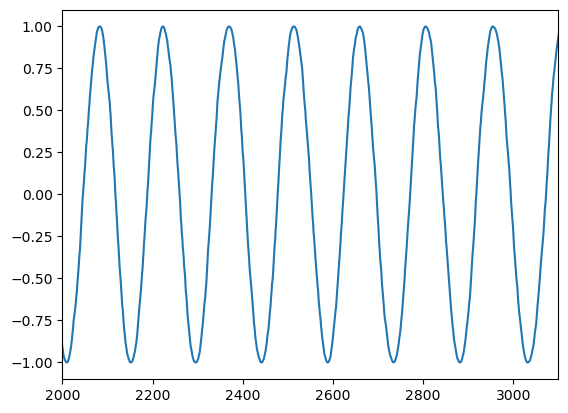

In [53]:
plt.plot(a)
plt.xlim(2000, 3100)